Connected to mechinterp (Python 3.10.15)

In [1]:
import os
import gc
import torch
os.chdir("/work/pi_jensen_umass_edu/jnainani_umass_edu/CircuitAnalysisSAEs")
import json
from sae_lens import SAE, HookedSAETransformer
from circ4latents import data_gen
from functools import partial
import einops

# Function to manage CUDA memory and clean up
def cleanup_cuda():
   torch.cuda.empty_cache()
   gc.collect()
# cleanup_cuda()
# Load the config
with open("config.json", 'r') as file:
   config = json.load(file)
token = config.get('huggingface_token', None)
os.environ["HF_TOKEN"] = token

# Define device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

hf_cache = "/work/pi_jensen_umass_edu/jnainani_umass_edu/mechinterp/huggingface_cache/hub"
os.environ["HF_HOME"] = hf_cache

# Load the model
model = HookedSAETransformer.from_pretrained("google/gemma-2-9b", device=device, cache_dir=hf_cache)

layers= [7, 14, 21, 40]
saes = [SAE.from_pretrained(release="gemma-scope-9b-pt-res-canonical", sae_id=f"layer_{layer}/width_16k/canonical", device=device)[0] for layer in layers]

/work/pi_jensen_umass_edu/jnainani_umass_edu/mechinterp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


Loading checkpoint shards: 100%|██████████| 8/8 [00:01<00:00,  4.66it/s]


Loaded pretrained model google/gemma-2-9b into HookedTransformer


In [2]:
# Updated version to return JSON with more names and structure for correct and incorrect keying examples

import json
import random

# Expanding the name pool with a larger set of names
extended_name_pool = [
    "Bob", "Sam", "Lilly", "Rob", "Alice", "Charlie", "Sally", "Tom", "Jake", "Emily", 
    "Megan", "Chris", "Sophia", "James", "Oliver", "Isabella", "Mia", "Jackson", 
    "Emma", "Ava", "Lucas", "Benjamin", "Ethan", "Grace", "Olivia", "Liam", "Noah"
]

for name in extended_name_pool:
    assert len(model.tokenizer.encode(name)) == 2, f"Name {name} has more than 1 token"

# Function to generate the dataset with correct and incorrect keying into dictionaries
def generate_extended_dataset(name_pool, num_samples=5):
    dataset = []
    
    for _ in range(num_samples):
        # Randomly select 5 names from the pool
        selected_names = random.sample(name_pool, 5)
        # Assign random ages to the selected names
        age_dict = {name: random.randint(10, 19) for name in selected_names}
        
        # Create a correct example
        correct_name = random.choice(list(age_dict.keys()))
        correct_prompt = f'Type "help", "copyright", "credits" or "license" for more information.\n>>> age = {age_dict}\n>>> age["{correct_name}"]\n'
        correct_response = age_dict[correct_name]
        correct_token = str(correct_response)[0]
        
        # Create an incorrect example with a name not in the dictionary
        incorrect_name = random.choice([name for name in name_pool if name not in age_dict])
        incorrect_prompt = f'Type "help", "copyright", "credits" or "license" for more information.\n>>> age = {age_dict}\n>>> age["{incorrect_name}"]\n'
        incorrect_response = "Traceback"
        incorrect_token = "Traceback"
        
        # Append the pair of correct and incorrect examples
        dataset.append({
            "correct": {
                "prompt": correct_prompt,
                "response": correct_response,
                "token": correct_token
            },
            "error": {
                "prompt": incorrect_prompt,
                "response": incorrect_response,
                "token": incorrect_token
            }
        })
        
    return dataset

# Generate the extended dataset
json_dataset = generate_extended_dataset(extended_name_pool, num_samples=100_000)

# Output the JSON structure

In [3]:
clean_prompts = []
corr_prompts = []

answer_token = model.to_single_token("1")
traceback_token = model.to_single_token("Traceback")

for item in json_dataset[:50]:
    corr_prompts.append(item["correct"]["prompt"])
    clean_prompts.append(item["error"]["prompt"])

clean_tokens = model.to_tokens(clean_prompts)
corr_tokens = model.to_tokens(corr_prompts)

In [4]:
def logit_diff_fn(logits):
    err = logits[:, -1, traceback_token]
    no_err = logits[:, -1, answer_token]
    return (err - no_err).mean()

# Disable gradients for all parameters
for param in model.parameters():
   param.requires_grad_(False)

# # Compute logits for clean and corrupted samples
logits = model(clean_tokens)
clean_diff = logit_diff_fn(logits)

logits = model(corr_tokens)
corr_diff = logit_diff_fn(logits)

print(f"clean_diff: {clean_diff}")
print(f"corr_diff: {corr_diff}")

# # Cleanup
del logits
cleanup_cuda()

# # Define error type metric
def _err_type_metric(logits, clean_logit_diff, corr_logit_diff):
    patched_logit_diff = logit_diff_fn(logits)
    return (patched_logit_diff - corr_logit_diff) / (clean_logit_diff - corr_logit_diff)

err_metric_denoising = partial(_err_type_metric, clean_logit_diff=clean_diff, corr_logit_diff=corr_diff)

clean_diff: 7.066664695739746
corr_diff: -7.014579772949219


In [5]:
def run_with_saes_filtered_cache(tokens, filtered_ids, model, saes):
    with torch.no_grad():  # Global no_grad for performance
        
        # Ensure tokens is on the correct device
        tokens = torch.as_tensor(tokens, device=model.cfg.device)

        # Vectorized mask creation
        mask = ~torch.isin(tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]  # Equivalent to unsqueeze(-1)

        sae_outs = {}
        
        # Define and add hooks
        for sae in saes:
            hook_point = sae.cfg.hook_name
            
            def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                sae_outs[hook.name] = enc_sae.detach().cpu()
                modified_act = sae.decode(enc_sae)
                
                # Apply torch.where only if mask_expanded has True values
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_point, filtered_hook, dir='fwd')
        
        logits = model(tokens)
        model.reset_hooks()
        
    return logits, sae_outs


# def run_with_saes_latent_op_patch(new_tokens, filtered_ids, model, saes, cache, dict_feats):
#     with torch.no_grad():  # Global no_grad for efficiency

#         # Ensure new_tokens is on the correct device
#         device = model.cfg.device
#         new_tokens = torch.as_tensor(new_tokens, device=device)

#         # Vectorized mask creation
#         mask = ~torch.isin(new_tokens, torch.tensor(filtered_ids, device=device))
#         mask_expanded = mask[:, :, None]

#         # Define and add hooks
#         for sae in saes:
#             hook_point = sae.cfg.hook_name
            
#             def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
#                 enc_sae = sae.encode(act).to(device)  # Ensure enc_sae is on the correct device

#                 if hook.name in cache and hook.name in dict_feats:
#                     prev_sae = cache[hook.name].to(device)  # Move cache tensor to device
#                     feature_indices = torch.tensor(dict_feats[hook.name], device=device)  # Move feature indices to device if not already

#                     # Vectorized feature assignment
#                     enc_sae[:, :, feature_indices] = prev_sae[:, :, feature_indices]

#                 modified_act = sae.decode(enc_sae)
#                 updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
#                 return updated_act
            
#             model.add_hook(hook_point, filtered_hook, dir='fwd')
        
#         logits = model(new_tokens)
#         model.reset_hooks()
        
#     return logits


def run_with_saes_latent_op_patch(new_tokens, filtered_ids, model, saes, cache, dict_feats):
   # Ensure tokens are a torch.Tensor
   if not isinstance(new_tokens, torch.Tensor):
       new_tokens = torch.tensor(new_tokens).to(model.cfg.device)  # Move to the device of the model

   # Create a mask where True indicates positions to modify
   mask = torch.ones_like(new_tokens, dtype=torch.bool)
   for token_id in filtered_ids:
       mask &= new_tokens != token_id

   # Expand the mask once, so it matches the shape [batch_size, seq_len, 1]
   mask_expanded = mask.unsqueeze(-1)  # Expand to allow broadcasting
   mask_expanded = mask_expanded.to(model.cfg.device)  # Move the mask to the same device as the model
   # For each SAE, add the appropriate hook
   for sae in saes:
       hook_point = sae.cfg.hook_name

       # Define the filtered hook function (optimized)
       def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
           # Apply the SAE only where mask_expanded is True
           enc_sae = sae.encode(act)  # Call the SAE once
          
           if hook.name in cache and hook.name in dict_feats:
               prev_sae = cache[hook.name].to(device)   # Get cached activations from the cache
               feature_indices = dict_feats[hook.name]  # Get the feature indices to patch

               for feature_idx in range(sae.cfg.d_sae):
                   if feature_idx in feature_indices:
                       enc_sae[:, :, feature_idx] = prev_sae[:, :, feature_idx]

           # After patching, decode the modified enc_sae
           modified_act = sae.decode(enc_sae)

           # In-place update where the mask is True
           updated_act = torch.where(mask_expanded, modified_act, act)

           return updated_act

       # Add the hook to the model
       model.add_hook(hook_point, filtered_hook, dir='fwd')

   # Run the model with the tokens (no gradients needed)
   with torch.no_grad():
       logits = model(new_tokens)

   # Reset the hooks after computation to free memory
   model.reset_hooks()

   return logits  # Return only the logits

def run_with_saes_latent_op_patch_cache(new_tokens, filtered_ids, model, saes, cache, dict_feats):
    with torch.no_grad():  # Global no_grad for efficiency

        # Ensure new_tokens is a tensor on the correct device
        new_tokens = torch.as_tensor(new_tokens, device=model.cfg.device)
        
        # Create mask in a vectorized way
        mask = ~torch.isin(new_tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]  # Expand dimensions directly
        
        # Cache hook names and feature indices outside the hook
        sae_hook_configs = [(sae.cfg.hook_name, sae, dict_feats.get(sae.cfg.hook_name, [])) for sae in saes]
        sae_outs = {}

        # Define and apply hooks
        for hook_name, sae, feature_indices in sae_hook_configs:
            def filtered_hook(act, hook, sae=sae, feature_indices=feature_indices, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                if hook.name in cache and feature_indices:
                    # Vectorized update of selected feature indices
                    enc_sae[:, :, feature_indices] = cache[hook.name][:, :, feature_indices].to(device) 

                sae_outs[hook.name] = enc_sae.detach().cpu()
                modified_act = sae.decode(enc_sae)
                
                # Only apply torch.where if needed
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_name, filtered_hook, dir='fwd')

        logits = model(new_tokens)
        model.reset_hooks()

    return logits, sae_outs
    
def run_with_saes_zero_ablation(tokens, filtered_ids, model, saes, dict_feats):
    with torch.no_grad():  # Global no_grad for performance

        # Ensure tokens is on the correct device
        tokens = torch.as_tensor(tokens, device=model.cfg.device)

        # Vectorized mask creation
        mask = ~torch.isin(tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]

        # Define and add hooks
        for sae in saes:
            hook_point = sae.cfg.hook_name
            
            def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                
                if hook.name in dict_feats:
                    feature_indices = dict_feats[hook.name]
                    # Use advanced indexing to zero-out non-selected features
                    all_indices = torch.arange(sae.cfg.d_sae, device=model.cfg.device)
                    zero_indices = all_indices[~torch.isin(all_indices, torch.tensor(feature_indices, device=model.cfg.device))]
                    enc_sae[:, :, zero_indices] = 0

                modified_act = sae.decode(enc_sae)
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_point, filtered_hook, dir='fwd')
        
        logits = model(tokens)
        model.reset_hooks()
        
    return logits

In [6]:
with open('mask_finding/mask.json') as f:
    mask = json.load(f)
mask

{'blocks.7.hook_resid_post': [75,
  351,
  488,
  632,
  1422,
  1575,
  1589,
  1662,
  1935,
  1949,
  1976,
  2467,
  2701,
  2846,
  2881,
  3153,
  3231,
  3257,
  3354,
  3418,
  3524,
  3658,
  3784,
  3985,
  3992,
  4287,
  5196,
  5311,
  5337,
  5459,
  5537,
  5587,
  6491,
  6500,
  6535,
  6671,
  6800,
  6928,
  6984,
  7008,
  7024,
  7323,
  7857,
  7958,
  8146,
  8667,
  8895,
  9046,
  9052,
  9353,
  9513,
  9681,
  9850,
  10093,
  10094,
  10180,
  10267,
  10647,
  10680,
  10768,
  10868,
  11204,
  11526,
  11635,
  11707,
  11740,
  12134,
  12275,
  12387,
  12407,
  12571,
  12880,
  12956,
  13383,
  13407,
  13630,
  13635,
  13694,
  14249,
  14309,
  14342,
  14615,
  14827,
  15328,
  15462,
  15613,
  15678,
  15738,
  15796,
  16179],
 'blocks.14.hook_resid_post': [56,
  207,
  357,
  461,
  520,
  738,
  849,
  850,
  985,
  1153,
  1158,
  1401,
  1564,
  1919,
  1977,
  2047,
  2186,
  2452,
  2463,
  2567,
  2602,
  2770,
  2796,
  2894,
  2936,


In [7]:
model.reset_hooks()
filtered_ids = [model.tokenizer.bos_token_id]
clean_sae_logits, clean_sae_cache = run_with_saes_filtered_cache(clean_tokens, filtered_ids, model, saes)
corr_sae_logits, corr_sae_cache = run_with_saes_filtered_cache(corr_tokens, filtered_ids, model, saes)

clean_sae_diff = logit_diff_fn(clean_sae_logits)
corr_sae_diff = logit_diff_fn(corr_sae_logits)

print(f"clean_sae_diff: {clean_sae_diff}")
print(f"corr_sae_diff: {corr_sae_diff}")

clean_sae_diff: 2.1551032066345215
corr_sae_diff: -6.801651954650879


In [8]:
logits = run_with_saes_zero_ablation(clean_tokens, filtered_ids, model, saes, mask)
clean_sae_diff_ablation = logit_diff_fn(logits)
print(f"clean_sae_diff_ablation: {clean_sae_diff_ablation}")

logits = run_with_saes_zero_ablation(corr_tokens, filtered_ids, model, saes, mask)
corr_sae_diff_ablation = logit_diff_fn(logits)
print(f"corr_sae_diff_ablation: {corr_sae_diff_ablation}")

clean_sae_diff_ablation: 0.6107855439186096
corr_sae_diff_ablation: -1.474082350730896


In [9]:
from sklearn.metrics import silhouette_score
import numpy as np

# Range of cluster numbers to try
cluster_range = range(2, 10)
layer = 'blocks.40.hook_resid_post'
best_score = -1
best_n_clusters = 2

# Compute cosine similarity
cos_sim_matrix = cosine_similarity(sum_vectors[layer].cpu().numpy())
distance_matrix = 1 - cos_sim_matrix  # Convert similarity to distance for clustering

# Ensure the diagonal is zero for silhouette_score
np.fill_diagonal(distance_matrix, 0)

# Test different numbers of clusters and calculate silhouette scores
for n_clusters in cluster_range:
    clustering_model = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
    latent_groups = clustering_model.fit_predict(distance_matrix)
    
    # Compute silhouette score
    score = silhouette_score(distance_matrix, latent_groups, metric='precomputed')
    print(f"Silhouette Score for {n_clusters} clusters: {score}")
    # Update best score and number of clusters if improved
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters

print(f"Optimal number of clusters: {best_n_clusters} with silhouette score: {best_score}")

NameError: name 'cosine_similarity' is not defined

In [10]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity

# 1. Average the activation cache across the batch dimension for both clean and corrupted
clean_sae_cache_means = {layer: sae_cache.mean(dim=0) for layer, sae_cache in clean_sae_cache.items()}
corr_sae_cache_means = {layer: sae_cache.mean(dim=0) for layer, sae_cache in corr_sae_cache.items()}

# 2. Initialize a dictionary to store the combined vectors for each latent and their clean-corrupted difference
combined_vectors = {}
sum_vectors = {}
diff_vectors = {}

# 3. Compute vectors for each layer and each latent specified in the mask
for layer, latents in mask.items():
    combined_vectors[layer] = []
    diff_vectors[layer] = []
    sum_vectors[layer] = []
    
    for latent in latents:
        # Get the clean and corrupted activations for the specified latent at the given layer
        clean_vector = clean_sae_cache_means[layer][:, latent]
        corr_vector = corr_sae_cache_means[layer][:, latent]
        
        # Stack clean and corrupted vectors to create a 2 * seq_len vector for each latent
        combined_vector = torch.cat([clean_vector, corr_vector], dim=0)
        combined_vectors[layer].append(combined_vector)
        
        # Compute the clean-corrupted difference vector
        diff_vector = clean_vector - corr_vector
        diff_vectors[layer].append(diff_vector)

        # Compute the sum vector
        sum_vector = clean_vector + corr_vector
        sum_vectors[layer].append(sum_vector)

    # Convert lists to tensors
    combined_vectors[layer] = torch.stack(combined_vectors[layer])  # shape: (n_latents, 2 * seq_len)
    diff_vectors[layer] = torch.stack(diff_vectors[layer])          # shape: (n_latents, seq_len)
    sum_vectors[layer] = torch.stack(sum_vectors[layer])          # shape: (n_latents, seq_len)

# 4. Compute cosine similarities between latents using the combined vectors
grouped_latents = {}
for layer in mask.keys():
    # Compute cosine similarity for combined vectors
    cos_sim_matrix = cosine_similarity(combined_vectors[layer].cpu().numpy())
    
    # 5. Apply clustering (Agglomerative Clustering) based on cosine similarity
    clustering_model = AgglomerativeClustering(metric='precomputed', linkage='average')
    latent_groups = clustering_model.fit_predict(1 - cos_sim_matrix)  # 1 - cosine similarity as a distance measure
    
    # Store the group labels for each latent in this layer
    grouped_latents[layer] = latent_groups

# Now `grouped_latents` contains clusters for each latent in each layer based on clean/corrupted vectors.
print(grouped_latents)

{'blocks.7.hook_resid_post': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1]), 'blocks.14.hook_resid_post': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0]), 'blocks.21.hook_resid_post': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [11]:
latent_n_clusters = {'blocks.40.hook_resid_post': 4, 'blocks.21.hook_resid_post': 2, 'blocks.14.hook_resid_post': 3, 'blocks.7.hook_resid_post': 5}
grouped_latents_diff = {}
for layer in mask.keys():
    # Compute cosine similarity for combined vectors
    cos_sim_matrix = cosine_similarity(diff_vectors[layer].cpu().numpy())
    
    # 5. Apply clustering (Agglomerative Clustering) based on cosine similarity
    clustering_model = AgglomerativeClustering(n_clusters=latent_n_clusters[layer], metric='precomputed', linkage='average')
    latent_groups = clustering_model.fit_predict(1 - cos_sim_matrix)  # 1 - cosine similarity as a distance measure
    
    # Store the group labels for each latent in this layer
    grouped_latents_diff[layer] = latent_groups

# Now `grouped_latents` contains clusters for each latent in each layer based on clean/corrupted vectors.
print(grouped_latents_diff)

{'blocks.7.hook_resid_post': array([1, 0, 0, 2, 0, 1, 0, 2, 3, 0, 0, 2, 0, 1, 0, 0, 1, 2, 0, 0, 1, 0,
       3, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 2, 2, 0, 0, 0, 0,
       0, 1, 2, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 1, 2, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 3, 0, 0, 3, 2, 0, 3, 2, 0,
       1, 4]), 'blocks.14.hook_resid_post': array([0, 0, 2, 0, 0, 1, 2, 0, 0, 0, 0, 0, 2, 1, 0, 2, 0, 1, 2, 0, 1, 1,
       2, 0, 0, 0, 2, 2, 0, 2, 1, 0, 1, 2, 2, 1, 1, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 2, 0, 1, 2, 0, 0, 2, 1, 0, 2, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 2, 1, 0, 0, 0, 1, 2, 0, 0, 0, 2, 1, 0,
       0, 0, 1, 2, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 2, 1, 0, 2, 2, 0, 2, 0, 1, 0, 1, 0, 1, 2, 0, 0,
       0, 0, 2, 0, 2, 0, 1]), 'blocks.21.hook_resid_post': array([0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0

In [12]:
from sklearn.metrics import silhouette_score
import numpy as np

# Range of cluster numbers to try
cluster_range = range(2, 10)
layer = 'blocks.40.hook_resid_post'
best_score = -1
best_n_clusters = 2

# Compute cosine similarity
cos_sim_matrix = cosine_similarity(sum_vectors[layer].cpu().numpy())
distance_matrix = 1 - cos_sim_matrix  # Convert similarity to distance for clustering

# Ensure the diagonal is zero for silhouette_score
np.fill_diagonal(distance_matrix, 0)

# Test different numbers of clusters and calculate silhouette scores
for n_clusters in cluster_range:
    clustering_model = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
    latent_groups = clustering_model.fit_predict(distance_matrix)
    
    # Compute silhouette score
    score = silhouette_score(distance_matrix, latent_groups, metric='precomputed')
    print(f"Silhouette Score for {n_clusters} clusters: {score}")
    # Update best score and number of clusters if improved
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters

print(f"Optimal number of clusters: {best_n_clusters} with silhouette score: {best_score}")

Silhouette Score for 2 clusters: 0.16430477797985077
Silhouette Score for 3 clusters: 0.17563611268997192
Silhouette Score for 4 clusters: 0.17563611268997192
Silhouette Score for 5 clusters: 0.17563611268997192
Silhouette Score for 6 clusters: 0.17563611268997192
Silhouette Score for 7 clusters: 0.17563611268997192
Silhouette Score for 8 clusters: 0.17563611268997192
Silhouette Score for 9 clusters: 0.15869228541851044
Optimal number of clusters: 3 with silhouette score: 0.17563611268997192


In [13]:
from sklearn.metrics import silhouette_score
import numpy as np

# Range of cluster numbers to try
cluster_range = range(2, 10)
layer = 'blocks.21.hook_resid_post'
best_score = -1
best_n_clusters = 2

# Compute cosine similarity
cos_sim_matrix = cosine_similarity(sum_vectors[layer].cpu().numpy())
distance_matrix = 1 - cos_sim_matrix  # Convert similarity to distance for clustering

# Ensure the diagonal is zero for silhouette_score
np.fill_diagonal(distance_matrix, 0)

# Test different numbers of clusters and calculate silhouette scores
for n_clusters in cluster_range:
    clustering_model = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
    latent_groups = clustering_model.fit_predict(distance_matrix)
    
    # Compute silhouette score
    score = silhouette_score(distance_matrix, latent_groups, metric='precomputed')
    print(f"Silhouette Score for {n_clusters} clusters: {score}")
    # Update best score and number of clusters if improved
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters

print(f"Optimal number of clusters: {best_n_clusters} with silhouette score: {best_score}")

Silhouette Score for 2 clusters: 0.14198917150497437
Silhouette Score for 3 clusters: 0.14198917150497437
Silhouette Score for 4 clusters: 0.14198917150497437
Silhouette Score for 5 clusters: 0.14198917150497437
Silhouette Score for 6 clusters: 0.15651382505893707
Silhouette Score for 7 clusters: 0.14335797727108002
Silhouette Score for 8 clusters: 0.19197334349155426
Silhouette Score for 9 clusters: 0.21621443331241608
Optimal number of clusters: 9 with silhouette score: 0.21621443331241608


In [14]:
from sklearn.metrics import silhouette_score
import numpy as np

# Range of cluster numbers to try
cluster_range = range(2, 20, 2)
layer = 'blocks.21.hook_resid_post'
best_score = -1
best_n_clusters = 2

# Compute cosine similarity
cos_sim_matrix = cosine_similarity(sum_vectors[layer].cpu().numpy())
distance_matrix = 1 - cos_sim_matrix  # Convert similarity to distance for clustering

# Ensure the diagonal is zero for silhouette_score
np.fill_diagonal(distance_matrix, 0)

# Test different numbers of clusters and calculate silhouette scores
for n_clusters in cluster_range:
    clustering_model = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
    latent_groups = clustering_model.fit_predict(distance_matrix)
    
    # Compute silhouette score
    score = silhouette_score(distance_matrix, latent_groups, metric='precomputed')
    print(f"Silhouette Score for {n_clusters} clusters: {score}")
    # Update best score and number of clusters if improved
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters

print(f"Optimal number of clusters: {best_n_clusters} with silhouette score: {best_score}")

Silhouette Score for 2 clusters: 0.14198917150497437
Silhouette Score for 4 clusters: 0.14198917150497437
Silhouette Score for 6 clusters: 0.15651382505893707
Silhouette Score for 8 clusters: 0.19197334349155426
Silhouette Score for 10 clusters: 0.28685447573661804
Silhouette Score for 12 clusters: 0.30383187532424927
Silhouette Score for 14 clusters: 0.32453688979148865
Silhouette Score for 16 clusters: 0.3320654332637787
Silhouette Score for 18 clusters: 0.359773725271225
Optimal number of clusters: 18 with silhouette score: 0.359773725271225


In [15]:
from sklearn.metrics import silhouette_score
import numpy as np

# Range of cluster numbers to try
cluster_range = range(2, 30, 3)
layer = 'blocks.21.hook_resid_post'
best_score = -1
best_n_clusters = 2

# Compute cosine similarity
cos_sim_matrix = cosine_similarity(sum_vectors[layer].cpu().numpy())
distance_matrix = 1 - cos_sim_matrix  # Convert similarity to distance for clustering

# Ensure the diagonal is zero for silhouette_score
np.fill_diagonal(distance_matrix, 0)

# Test different numbers of clusters and calculate silhouette scores
for n_clusters in cluster_range:
    clustering_model = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
    latent_groups = clustering_model.fit_predict(distance_matrix)
    
    # Compute silhouette score
    score = silhouette_score(distance_matrix, latent_groups, metric='precomputed')
    print(f"Silhouette Score for {n_clusters} clusters: {score}")
    # Update best score and number of clusters if improved
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters

print(f"Optimal number of clusters: {best_n_clusters} with silhouette score: {best_score}")

Silhouette Score for 2 clusters: 0.14198917150497437
Silhouette Score for 5 clusters: 0.14198917150497437
Silhouette Score for 8 clusters: 0.19197334349155426
Silhouette Score for 11 clusters: 0.2806212902069092
Silhouette Score for 14 clusters: 0.32453688979148865
Silhouette Score for 17 clusters: 0.34856167435646057
Silhouette Score for 20 clusters: 0.39667096734046936
Silhouette Score for 23 clusters: 0.41264107823371887
Silhouette Score for 26 clusters: 0.4161297380924225
Silhouette Score for 29 clusters: 0.407266229391098
Optimal number of clusters: 26 with silhouette score: 0.4161297380924225


In [16]:
from sklearn.metrics import silhouette_score
import numpy as np

# Range of cluster numbers to try
cluster_range = range(2, 30, 3)
layer = 'blocks.14.hook_resid_post'
best_score = -1
best_n_clusters = 2

# Compute cosine similarity
cos_sim_matrix = cosine_similarity(sum_vectors[layer].cpu().numpy())
distance_matrix = 1 - cos_sim_matrix  # Convert similarity to distance for clustering

# Ensure the diagonal is zero for silhouette_score
np.fill_diagonal(distance_matrix, 0)

# Test different numbers of clusters and calculate silhouette scores
for n_clusters in cluster_range:
    clustering_model = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
    latent_groups = clustering_model.fit_predict(distance_matrix)
    
    # Compute silhouette score
    score = silhouette_score(distance_matrix, latent_groups, metric='precomputed')
    print(f"Silhouette Score for {n_clusters} clusters: {score}")
    # Update best score and number of clusters if improved
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters

print(f"Optimal number of clusters: {best_n_clusters} with silhouette score: {best_score}")

Silhouette Score for 2 clusters: 0.1969195455312729
Silhouette Score for 5 clusters: 0.25006797909736633
Silhouette Score for 8 clusters: 0.3059874176979065
Silhouette Score for 11 clusters: 0.3767786920070648
Silhouette Score for 14 clusters: 0.42608633637428284
Silhouette Score for 17 clusters: 0.42660683393478394
Silhouette Score for 20 clusters: 0.44437944889068604
Silhouette Score for 23 clusters: 0.45446062088012695
Silhouette Score for 26 clusters: 0.4525870978832245
Silhouette Score for 29 clusters: 0.422113299369812
Optimal number of clusters: 23 with silhouette score: 0.45446062088012695


In [17]:
from sklearn.metrics import silhouette_score
import numpy as np

# Range of cluster numbers to try
cluster_range = range(2, 30, 3)
layer = 'blocks.7.hook_resid_post'
best_score = -1
best_n_clusters = 2

# Compute cosine similarity
cos_sim_matrix = cosine_similarity(sum_vectors[layer].cpu().numpy())
distance_matrix = 1 - cos_sim_matrix  # Convert similarity to distance for clustering

# Ensure the diagonal is zero for silhouette_score
np.fill_diagonal(distance_matrix, 0)

# Test different numbers of clusters and calculate silhouette scores
for n_clusters in cluster_range:
    clustering_model = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
    latent_groups = clustering_model.fit_predict(distance_matrix)
    
    # Compute silhouette score
    score = silhouette_score(distance_matrix, latent_groups, metric='precomputed')
    print(f"Silhouette Score for {n_clusters} clusters: {score}")
    # Update best score and number of clusters if improved
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters

print(f"Optimal number of clusters: {best_n_clusters} with silhouette score: {best_score}")

Silhouette Score for 2 clusters: 0.10160481184720993
Silhouette Score for 5 clusters: 0.20867577195167542
Silhouette Score for 8 clusters: 0.2698715031147003
Silhouette Score for 11 clusters: 0.3411098122596741
Silhouette Score for 14 clusters: 0.382377952337265
Silhouette Score for 17 clusters: 0.4348182678222656
Silhouette Score for 20 clusters: 0.45124006271362305
Silhouette Score for 23 clusters: 0.47909122705459595
Silhouette Score for 26 clusters: 0.46174532175064087
Silhouette Score for 29 clusters: 0.4850561022758484
Optimal number of clusters: 29 with silhouette score: 0.4850561022758484


In [18]:
from sklearn.metrics import silhouette_score
import numpy as np

# Range of cluster numbers to try
cluster_range = range(2, 40, 3)
layer = 'blocks.7.hook_resid_post'
best_score = -1
best_n_clusters = 2

# Compute cosine similarity
cos_sim_matrix = cosine_similarity(sum_vectors[layer].cpu().numpy())
distance_matrix = 1 - cos_sim_matrix  # Convert similarity to distance for clustering

# Ensure the diagonal is zero for silhouette_score
np.fill_diagonal(distance_matrix, 0)

# Test different numbers of clusters and calculate silhouette scores
for n_clusters in cluster_range:
    clustering_model = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
    latent_groups = clustering_model.fit_predict(distance_matrix)
    
    # Compute silhouette score
    score = silhouette_score(distance_matrix, latent_groups, metric='precomputed')
    print(f"Silhouette Score for {n_clusters} clusters: {score}")
    # Update best score and number of clusters if improved
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters

print(f"Optimal number of clusters: {best_n_clusters} with silhouette score: {best_score}")

Silhouette Score for 2 clusters: 0.10160481184720993
Silhouette Score for 5 clusters: 0.20867577195167542
Silhouette Score for 8 clusters: 0.2698715031147003
Silhouette Score for 11 clusters: 0.3411098122596741
Silhouette Score for 14 clusters: 0.382377952337265
Silhouette Score for 17 clusters: 0.4348182678222656
Silhouette Score for 20 clusters: 0.45124006271362305
Silhouette Score for 23 clusters: 0.47909122705459595
Silhouette Score for 26 clusters: 0.46174532175064087
Silhouette Score for 29 clusters: 0.4850561022758484
Silhouette Score for 32 clusters: 0.5141720771789551
Silhouette Score for 35 clusters: 0.5020731091499329
Silhouette Score for 38 clusters: 0.5205706357955933
Optimal number of clusters: 38 with silhouette score: 0.5205706357955933


In [19]:
from sklearn.metrics import silhouette_score
import numpy as np

# Range of cluster numbers to try
cluster_range = range(2, 50, 3)
layer = 'blocks.7.hook_resid_post'
best_score = -1
best_n_clusters = 2

# Compute cosine similarity
cos_sim_matrix = cosine_similarity(sum_vectors[layer].cpu().numpy())
distance_matrix = 1 - cos_sim_matrix  # Convert similarity to distance for clustering

# Ensure the diagonal is zero for silhouette_score
np.fill_diagonal(distance_matrix, 0)

# Test different numbers of clusters and calculate silhouette scores
for n_clusters in cluster_range:
    clustering_model = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
    latent_groups = clustering_model.fit_predict(distance_matrix)
    
    # Compute silhouette score
    score = silhouette_score(distance_matrix, latent_groups, metric='precomputed')
    print(f"Silhouette Score for {n_clusters} clusters: {score}")
    # Update best score and number of clusters if improved
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters

print(f"Optimal number of clusters: {best_n_clusters} with silhouette score: {best_score}")

Silhouette Score for 2 clusters: 0.10160481184720993
Silhouette Score for 5 clusters: 0.20867577195167542
Silhouette Score for 8 clusters: 0.2698715031147003
Silhouette Score for 11 clusters: 0.3411098122596741
Silhouette Score for 14 clusters: 0.382377952337265
Silhouette Score for 17 clusters: 0.4348182678222656
Silhouette Score for 20 clusters: 0.45124006271362305
Silhouette Score for 23 clusters: 0.47909122705459595
Silhouette Score for 26 clusters: 0.46174532175064087
Silhouette Score for 29 clusters: 0.4850561022758484
Silhouette Score for 32 clusters: 0.5141720771789551
Silhouette Score for 35 clusters: 0.5020731091499329
Silhouette Score for 38 clusters: 0.5205706357955933
Silhouette Score for 41 clusters: 0.5068932175636292
Silhouette Score for 44 clusters: 0.47510722279548645
Silhouette Score for 47 clusters: 0.45691999793052673
Optimal number of clusters: 38 with silhouette score: 0.5205706357955933


In [20]:
latent_n_clusters = {'blocks.40.hook_resid_post': 3, 'blocks.21.hook_resid_post': 26, 'blocks.14.hook_resid_post': 23, 'blocks.7.hook_resid_post': 38}
grouped_latents_diff = {}
for layer in mask.keys():
    # Compute cosine similarity for combined vectors
    cos_sim_matrix = cosine_similarity(diff_vectors[layer].cpu().numpy())
    
    # 5. Apply clustering (Agglomerative Clustering) based on cosine similarity
    clustering_model = AgglomerativeClustering(n_clusters=latent_n_clusters[layer], metric='precomputed', linkage='average')
    latent_groups = clustering_model.fit_predict(1 - cos_sim_matrix)  # 1 - cosine similarity as a distance measure
    
    # Store the group labels for each latent in this layer
    grouped_latents_diff[layer] = latent_groups

# Now `grouped_latents` contains clusters for each latent in each layer based on clean/corrupted vectors.
print(grouped_latents_diff)

{'blocks.7.hook_resid_post': array([ 1,  0,  0,  2,  4,  1,  0,  2,  3,  0,  0,  2,  4,  1,  0,  0,  1,
        2,  0,  0,  1,  4,  3,  0,  1,  4, 37, 36, 35,  4, 34,  1, 33,  4,
        4,  3, 32, 31,  2,  2, 30, 29, 28,  4, 27,  1,  2, 26, 25,  2,  2,
       24, 23,  2, 22,  2,  2,  1,  2,  1,  4,  1,  4,  1, 21, 20, 19, 18,
       17, 16,  2, 15,  2, 14, 13, 12,  2, 11,  4,  3,  9,  8,  3,  2,  7,
        3,  6,  5,  1, 10]), 'blocks.14.hook_resid_post': array([ 4,  0,  2,  0,  0,  1,  2,  0,  0,  0,  0,  0,  2,  1,  0,  2,  0,
        1,  2,  0,  1,  1,  2,  0,  0,  0,  2,  2,  0,  2,  1,  0,  1,  2,
        2,  1,  1,  0,  0,  2,  0,  0,  0,  4,  0,  0,  1,  0,  1,  0,  0,
        0,  1,  1,  0,  2,  0,  1,  2,  0,  0,  2,  1,  0,  2,  0,  1,  0,
        0,  0,  0,  1,  1,  0,  0,  2,  1,  0,  4,  0,  1,  2,  0,  0,  0,
        2,  1,  0,  0,  0,  1,  2,  0,  1,  0,  0, 22,  1, 21, 20, 19, 18,
        1,  2, 17,  1,  1,  1, 16, 15, 14,  1,  1,  1, 13,  1,  2,  1, 12,
        2,  2

In [21]:
latent_n_clusters = {'blocks.40.hook_resid_post': 3, 'blocks.21.hook_resid_post': 26, 'blocks.14.hook_resid_post': 23, 'blocks.7.hook_resid_post': 38}
grouped_latents_sum = {}
for layer in mask.keys():
    # Compute cosine similarity for combined vectors
    cos_sim_matrix = cosine_similarity(sum_vectors[layer].cpu().numpy())
    
    # 5. Apply clustering (Agglomerative Clustering) based on cosine similarity
    clustering_model = AgglomerativeClustering(n_clusters=latent_n_clusters[layer], metric='precomputed', linkage='average')
    latent_groups = clustering_model.fit_predict(1 - cos_sim_matrix)  # 1 - cosine similarity as a distance measure
    
    # Store the group labels for each latent in this layer
    grouped_latents_sum[layer] = latent_groups

# Now `grouped_latents` contains clusters for each latent in each layer based on clean/corrupted vectors.
print(grouped_latents_sum)

{'blocks.7.hook_resid_post': array([35, 30, 34,  4,  4,  5,  1,  4,  2,  8,  8, 14,  9,  3,  6, 10, 37,
        8, 14, 13,  5, 17,  2, 36, 10, 11, 13, 10, 31, 22,  8,  2, 14, 28,
       17, 20,  8, 10,  8,  8, 27,  8, 10,  4,  3, 26, 13, 10, 10, 21, 14,
       25,  7,  9, 10, 12,  3,  8, 19,  0, 28, 21,  9,  0, 11, 23, 11, 27,
        1, 20, 24, 13, 21,  6, 29,  1, 21, 33, 17,  8, 32, 30, 30,  7,  8,
       15, 16, 10,  7, 18]), 'blocks.14.hook_resid_post': array([ 7,  6, 14, 13,  9,  8,  2, 20, 20, 17,  1,  1,  9,  3,  9,  9,  1,
        8,  2,  1,  9, 14,  1,  9,  5, 15,  2,  2,  1,  9, 20,  1,  9,  9,
        9, 21, 19,  1,  4, 18, 20,  9,  4, 21, 16, 15,  2,  0,  2, 22,  3,
        5,  4,  8,  9, 22,  1,  9, 14,  7,  0,  2,  9,  9, 18,  9,  9, 17,
       10,  4,  6,  9,  9, 15,  9,  8, 18,  1, 21,  1, 20,  9,  1,  1,  1,
        9, 20,  9,  3,  9,  9, 18, 20, 13,  3,  2,  1,  4, 11, 20, 12,  1,
        9,  4,  0,  9,  9,  9,  9,  0,  1, 21,  9,  8, 15, 20,  9,  9, 15,
        0, 22

NameError: name 'cluster_diffs' is not defined

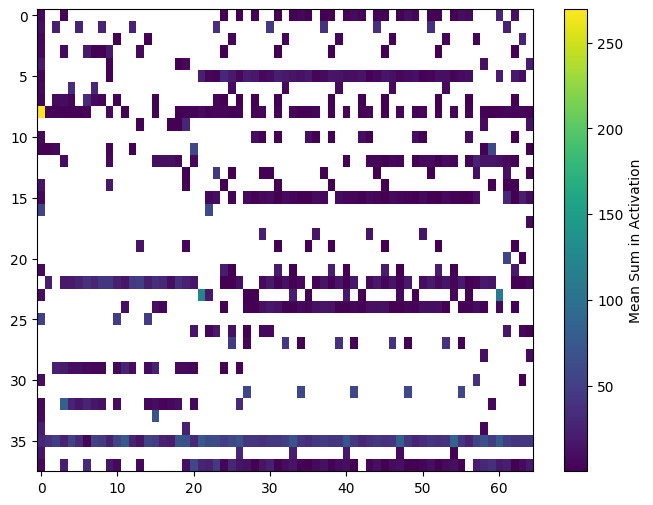

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import torch
# import matplotlib.colors as mcolors
# Assuming `model.to_str_tokens(clean_prompt[0])` provides the token labels for the x-axis
layer = 'blocks.7.hook_resid_post'
combined_vectors_layer = combined_vectors[layer]
diff_vectors_layer = diff_vectors[layer]
sum_vectors_layer = sum_vectors[layer]
clusters = grouped_latents_sum[layer]
tokens = model.to_str_tokens(clean_prompts[0])  # Get token labels for sequence length positions

# Summarization of Mean Difference Distribution for Each Cluster as a Heatmap
cluster_sums = {}
heatmap_data = []
latents_per_cluster = []
for cluster_id in np.unique(clusters):
    # Select diff vectors belonging to the current cluster
    cluster_indices = np.where(clusters == cluster_id)[0]
    cluster_sum_vectors = sum_vectors_layer[cluster_indices]
    latents_per_cluster.append(len(cluster_indices))
    # Calculate the mean difference across latents in this cluster
    cluster_mean_sum = cluster_sum_vectors.mean(dim=0).cpu().numpy()
    cluster_sums[cluster_id] = cluster_mean_sum
    heatmap_data.append(cluster_mean_sum)  # Collect for heatmap plot

# Convert to numpy array for plotting, with each row as a cluster and columns as sequence length positions
heatmap_data = np.array(heatmap_data)

# Select only the last 5 tokens
# heatmap_data = heatmap_data #[:, -25:]
# tokens = tokens[-25:]

# Create a color map with white for zero values
cmap = plt.cm.viridis
cmap.set_bad(color='white')

# Mask zeros in the heatmap data for white color
masked_heatmap_data = np.ma.masked_where(heatmap_data == 0, heatmap_data)

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(masked_heatmap_data, aspect='auto', cmap=cmap, interpolation='nearest')
plt.colorbar(label='Mean Sum in Activation')

# Set y-axis to show cluster labels and x-axis to show only the last 5 tokens
plt.yticks(ticks=range(len(cluster_diffs)), labels=[f'Cluster {i} - {latents_per_cluster[i]} latents' for i in range(len(cluster_diffs))])
plt.xticks(ticks=range(len(tokens)), labels=tokens, rotation=90)
layer_ind = 7
plt.title(f'Mean Sum (clean + corrupted) Distribution for Each Cluster Latents in Layer: {layer_ind}')
plt.xlabel('Last 15 Tokens in Sequence')
plt.ylabel('Cluster ID')
plt.show()

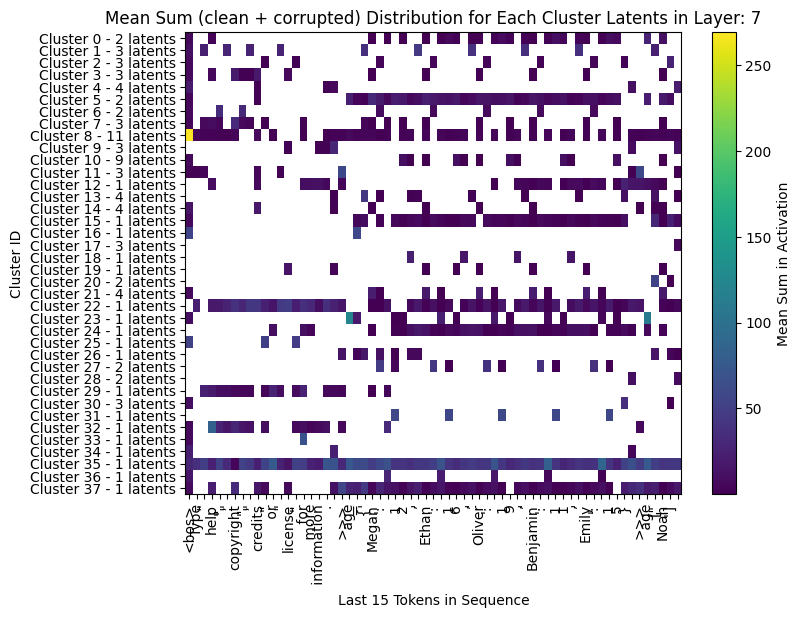

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import torch
# import matplotlib.colors as mcolors
# Assuming `model.to_str_tokens(clean_prompt[0])` provides the token labels for the x-axis
layer = 'blocks.7.hook_resid_post'
combined_vectors_layer = combined_vectors[layer]
diff_vectors_layer = diff_vectors[layer]
sum_vectors_layer = sum_vectors[layer]
clusters = grouped_latents_sum[layer]
tokens = model.to_str_tokens(clean_prompts[0])  # Get token labels for sequence length positions

# Summarization of Mean Difference Distribution for Each Cluster as a Heatmap
cluster_sums = {}
heatmap_data = []
latents_per_cluster = []
for cluster_id in np.unique(clusters):
    # Select diff vectors belonging to the current cluster
    cluster_indices = np.where(clusters == cluster_id)[0]
    cluster_sum_vectors = sum_vectors_layer[cluster_indices]
    latents_per_cluster.append(len(cluster_indices))
    # Calculate the mean difference across latents in this cluster
    cluster_mean_sum = cluster_sum_vectors.mean(dim=0).cpu().numpy()
    cluster_sums[cluster_id] = cluster_mean_sum
    heatmap_data.append(cluster_mean_sum)  # Collect for heatmap plot

# Convert to numpy array for plotting, with each row as a cluster and columns as sequence length positions
heatmap_data = np.array(heatmap_data)

# Select only the last 5 tokens
# heatmap_data = heatmap_data #[:, -25:]
# tokens = tokens[-25:]

# Create a color map with white for zero values
cmap = plt.cm.viridis
cmap.set_bad(color='white')

# Mask zeros in the heatmap data for white color
masked_heatmap_data = np.ma.masked_where(heatmap_data == 0, heatmap_data)

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(masked_heatmap_data, aspect='auto', cmap=cmap, interpolation='nearest')
plt.colorbar(label='Mean Sum in Activation')

# Set y-axis to show cluster labels and x-axis to show only the last 5 tokens
plt.yticks(ticks=range(len(cluster_sums)), labels=[f'Cluster {i} - {latents_per_cluster[i]} latents' for i in range(len(cluster_sums))])
plt.xticks(ticks=range(len(tokens)), labels=tokens, rotation=90)
layer_ind = 7
plt.title(f'Mean Sum (clean + corrupted) Distribution for Each Cluster Latents in Layer: {layer_ind}')
plt.xlabel('Last 15 Tokens in Sequence')
plt.ylabel('Cluster ID')
plt.show()

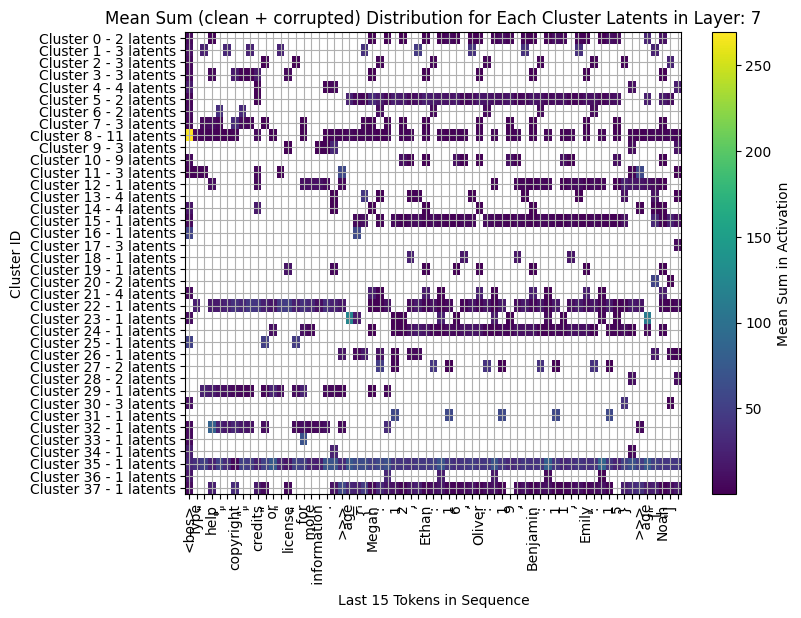

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import torch
# import matplotlib.colors as mcolors
# Assuming `model.to_str_tokens(clean_prompt[0])` provides the token labels for the x-axis
layer = 'blocks.7.hook_resid_post'
combined_vectors_layer = combined_vectors[layer]
diff_vectors_layer = diff_vectors[layer]
sum_vectors_layer = sum_vectors[layer]
clusters = grouped_latents_sum[layer]
tokens = model.to_str_tokens(clean_prompts[0])  # Get token labels for sequence length positions

# Summarization of Mean Difference Distribution for Each Cluster as a Heatmap
cluster_sums = {}
heatmap_data = []
latents_per_cluster = []
for cluster_id in np.unique(clusters):
    # Select diff vectors belonging to the current cluster
    cluster_indices = np.where(clusters == cluster_id)[0]
    cluster_sum_vectors = sum_vectors_layer[cluster_indices]
    latents_per_cluster.append(len(cluster_indices))
    # Calculate the mean difference across latents in this cluster
    cluster_mean_sum = cluster_sum_vectors.mean(dim=0).cpu().numpy()
    cluster_sums[cluster_id] = cluster_mean_sum
    heatmap_data.append(cluster_mean_sum)  # Collect for heatmap plot

# Convert to numpy array for plotting, with each row as a cluster and columns as sequence length positions
heatmap_data = np.array(heatmap_data)

# Select only the last 5 tokens
# heatmap_data = heatmap_data #[:, -25:]
# tokens = tokens[-25:]

# Create a color map with white for zero values
cmap = plt.cm.viridis
cmap.set_bad(color='white')

# Mask zeros in the heatmap data for white color
masked_heatmap_data = np.ma.masked_where(heatmap_data == 0, heatmap_data)

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(masked_heatmap_data, aspect='auto', cmap=cmap, interpolation='nearest')
plt.colorbar(label='Mean Sum in Activation')

# Set y-axis to show cluster labels and x-axis to show only the last 5 tokens
plt.yticks(ticks=range(len(cluster_sums)), labels=[f'Cluster {i} - {latents_per_cluster[i]} latents' for i in range(len(cluster_sums))])
plt.xticks(ticks=range(len(tokens)), labels=tokens, rotation=90)
layer_ind = 7
plt.title(f'Mean Sum (clean + corrupted) Distribution for Each Cluster Latents in Layer: {layer_ind}')
plt.xlabel('Last 15 Tokens in Sequence')
plt.ylabel('Cluster ID')
plt.grid()
plt.show()

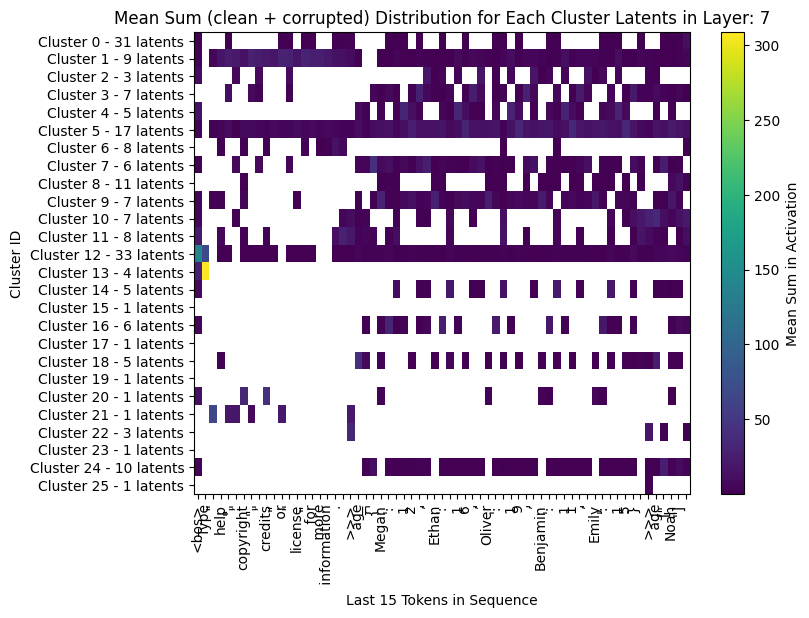

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import torch
# import matplotlib.colors as mcolors
# Assuming `model.to_str_tokens(clean_prompt[0])` provides the token labels for the x-axis
layer = 'blocks.21.hook_resid_post'
combined_vectors_layer = combined_vectors[layer]
diff_vectors_layer = diff_vectors[layer]
sum_vectors_layer = sum_vectors[layer]
clusters = grouped_latents_sum[layer]
tokens = model.to_str_tokens(clean_prompts[0])  # Get token labels for sequence length positions

# Summarization of Mean Difference Distribution for Each Cluster as a Heatmap
cluster_sums = {}
heatmap_data = []
latents_per_cluster = []
for cluster_id in np.unique(clusters):
    # Select diff vectors belonging to the current cluster
    cluster_indices = np.where(clusters == cluster_id)[0]
    cluster_sum_vectors = sum_vectors_layer[cluster_indices]
    latents_per_cluster.append(len(cluster_indices))
    # Calculate the mean difference across latents in this cluster
    cluster_mean_sum = cluster_sum_vectors.mean(dim=0).cpu().numpy()
    cluster_sums[cluster_id] = cluster_mean_sum
    heatmap_data.append(cluster_mean_sum)  # Collect for heatmap plot

# Convert to numpy array for plotting, with each row as a cluster and columns as sequence length positions
heatmap_data = np.array(heatmap_data)

# Select only the last 5 tokens
# heatmap_data = heatmap_data #[:, -25:]
# tokens = tokens[-25:]

# Create a color map with white for zero values
cmap = plt.cm.viridis
cmap.set_bad(color='white')

# Mask zeros in the heatmap data for white color
masked_heatmap_data = np.ma.masked_where(heatmap_data == 0, heatmap_data)

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(masked_heatmap_data, aspect='auto', cmap=cmap, interpolation='nearest')
plt.colorbar(label='Mean Sum in Activation')

# Set y-axis to show cluster labels and x-axis to show only the last 5 tokens
plt.yticks(ticks=range(len(cluster_sums)), labels=[f'Cluster {i} - {latents_per_cluster[i]} latents' for i in range(len(cluster_sums))])
plt.xticks(ticks=range(len(tokens)), labels=tokens, rotation=90)
layer_ind = 7
plt.title(f'Mean Sum (clean + corrupted) Distribution for Each Cluster Latents in Layer: {layer_ind}')
plt.xlabel('Last 15 Tokens in Sequence')
plt.ylabel('Cluster ID')
plt.show()

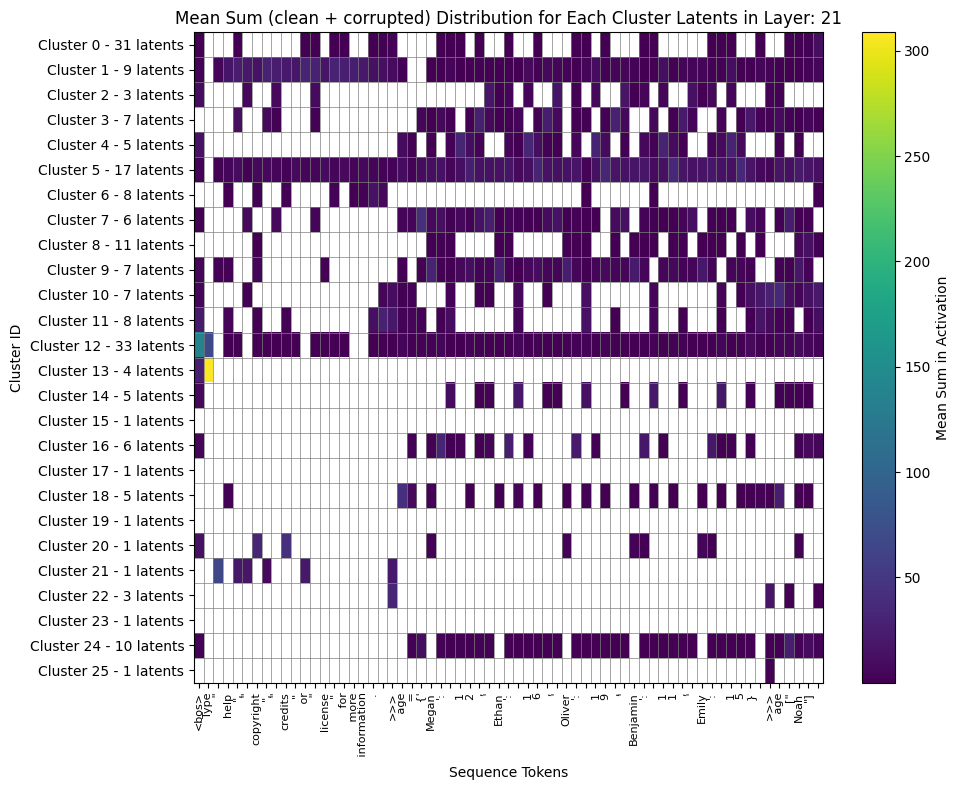

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming `model.to_str_tokens(clean_prompt[0])` provides the token labels for the x-axis
layer_ind = 21
layer = f'blocks.{layer_ind}.hook_resid_post'
combined_vectors_layer = combined_vectors[layer]
diff_vectors_layer = diff_vectors[layer]
sum_vectors_layer = sum_vectors[layer]
clusters = grouped_latents_sum[layer]
tokens = model.to_str_tokens(clean_prompts[0])  # Get token labels for sequence length positions

# Summarization of Mean Difference Distribution for Each Cluster as a Heatmap
cluster_sums = {}
heatmap_data = []
latents_per_cluster = []
for cluster_id in np.unique(clusters):
    # Select diff vectors belonging to the current cluster
    cluster_indices = np.where(clusters == cluster_id)[0]
    cluster_sum_vectors = sum_vectors_layer[cluster_indices]
    latents_per_cluster.append(len(cluster_indices))
    # Calculate the mean difference across latents in this cluster
    cluster_mean_sum = cluster_sum_vectors.mean(dim=0).cpu().numpy()
    cluster_sums[cluster_id] = cluster_mean_sum
    heatmap_data.append(cluster_mean_sum)  # Collect for heatmap plot

# Convert to numpy array for plotting, with each row as a cluster and columns as sequence length positions
heatmap_data = np.array(heatmap_data)

# Create a color map with white for zero values
cmap = plt.cm.viridis
cmap.set_bad(color='white')

# Mask zeros in the heatmap data for white color
masked_heatmap_data = np.ma.masked_where(heatmap_data == 0, heatmap_data)

# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(masked_heatmap_data, aspect='auto', cmap=cmap, interpolation='nearest')
plt.colorbar(label='Mean Sum in Activation')

# Set y-axis to show cluster labels and x-axis to show the last 15 tokens
plt.yticks(ticks=range(len(cluster_sums)), labels=[f'Cluster {i} - {latents_per_cluster[i]} latents' for i in range(len(cluster_sums))])
plt.xticks(ticks=range(len(tokens)), labels=tokens, rotation=90, fontsize=8)  # Reduce x-axis font size to avoid overlap

# Add lines to separate rows and columns
for row in range(1, len(cluster_sums)):
    plt.hlines(row - 0.5, xmin=-0.5, xmax=len(tokens) - 0.5, color='gray', linewidth=0.5)

for col in range(1, len(tokens)):
    plt.vlines(col - 0.5, ymin=-0.5, ymax=len(cluster_sums) - 0.5, color='gray', linewidth=0.5)

# Title and axis labels
plt.title(f'Mean Sum (clean + corrupted) Distribution for Each Cluster Latents in Layer: {layer_ind}')
plt.xlabel('Sequence Tokens')
plt.ylabel('Cluster ID')
plt.tight_layout()
plt.show()

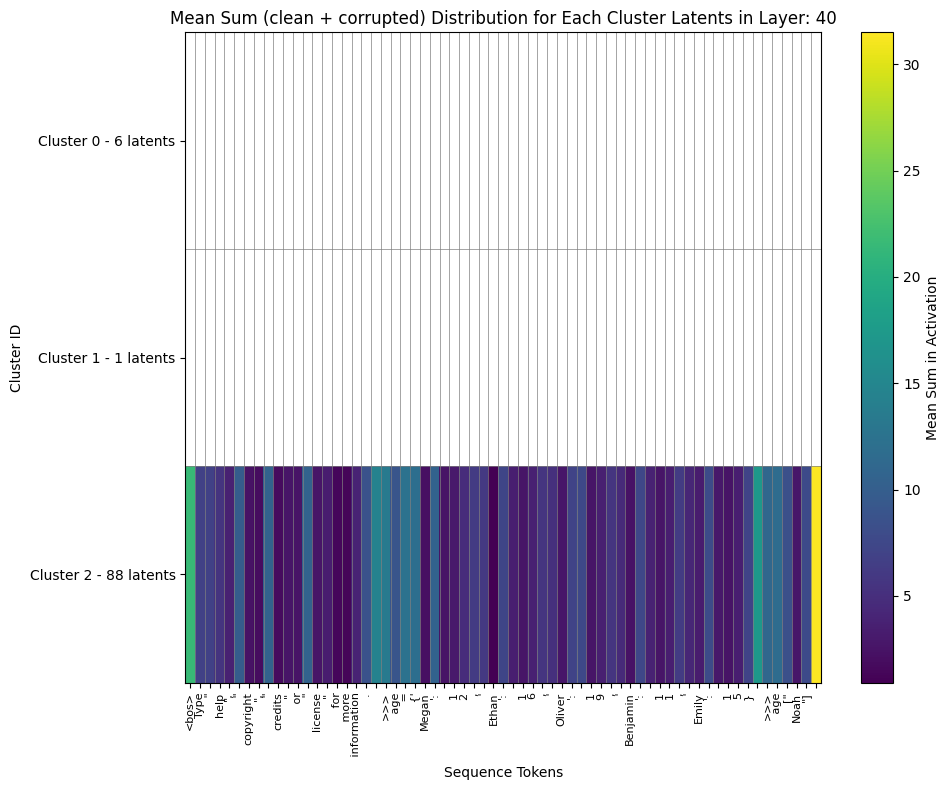

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming `model.to_str_tokens(clean_prompt[0])` provides the token labels for the x-axis
layer_ind = 40
layer = f'blocks.{layer_ind}.hook_resid_post'
combined_vectors_layer = combined_vectors[layer]
diff_vectors_layer = diff_vectors[layer]
sum_vectors_layer = sum_vectors[layer]
clusters = grouped_latents_sum[layer]
tokens = model.to_str_tokens(clean_prompts[0])  # Get token labels for sequence length positions

# Summarization of Mean Difference Distribution for Each Cluster as a Heatmap
cluster_sums = {}
heatmap_data = []
latents_per_cluster = []
for cluster_id in np.unique(clusters):
    # Select diff vectors belonging to the current cluster
    cluster_indices = np.where(clusters == cluster_id)[0]
    cluster_sum_vectors = sum_vectors_layer[cluster_indices]
    latents_per_cluster.append(len(cluster_indices))
    # Calculate the mean difference across latents in this cluster
    cluster_mean_sum = cluster_sum_vectors.mean(dim=0).cpu().numpy()
    cluster_sums[cluster_id] = cluster_mean_sum
    heatmap_data.append(cluster_mean_sum)  # Collect for heatmap plot

# Convert to numpy array for plotting, with each row as a cluster and columns as sequence length positions
heatmap_data = np.array(heatmap_data)

# Create a color map with white for zero values
cmap = plt.cm.viridis
cmap.set_bad(color='white')

# Mask zeros in the heatmap data for white color
masked_heatmap_data = np.ma.masked_where(heatmap_data == 0, heatmap_data)

# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(masked_heatmap_data, aspect='auto', cmap=cmap, interpolation='nearest')
plt.colorbar(label='Mean Sum in Activation')

# Set y-axis to show cluster labels and x-axis to show the last 15 tokens
plt.yticks(ticks=range(len(cluster_sums)), labels=[f'Cluster {i} - {latents_per_cluster[i]} latents' for i in range(len(cluster_sums))])
plt.xticks(ticks=range(len(tokens)), labels=tokens, rotation=90, fontsize=8)  # Reduce x-axis font size to avoid overlap

# Add lines to separate rows and columns
for row in range(1, len(cluster_sums)):
    plt.hlines(row - 0.5, xmin=-0.5, xmax=len(tokens) - 0.5, color='gray', linewidth=0.5)

for col in range(1, len(tokens)):
    plt.vlines(col - 0.5, ymin=-0.5, ymax=len(cluster_sums) - 0.5, color='gray', linewidth=0.5)

# Title and axis labels
plt.title(f'Mean Sum (clean + corrupted) Distribution for Each Cluster Latents in Layer: {layer_ind}')
plt.xlabel('Sequence Tokens')
plt.ylabel('Cluster ID')
plt.tight_layout()
plt.show()

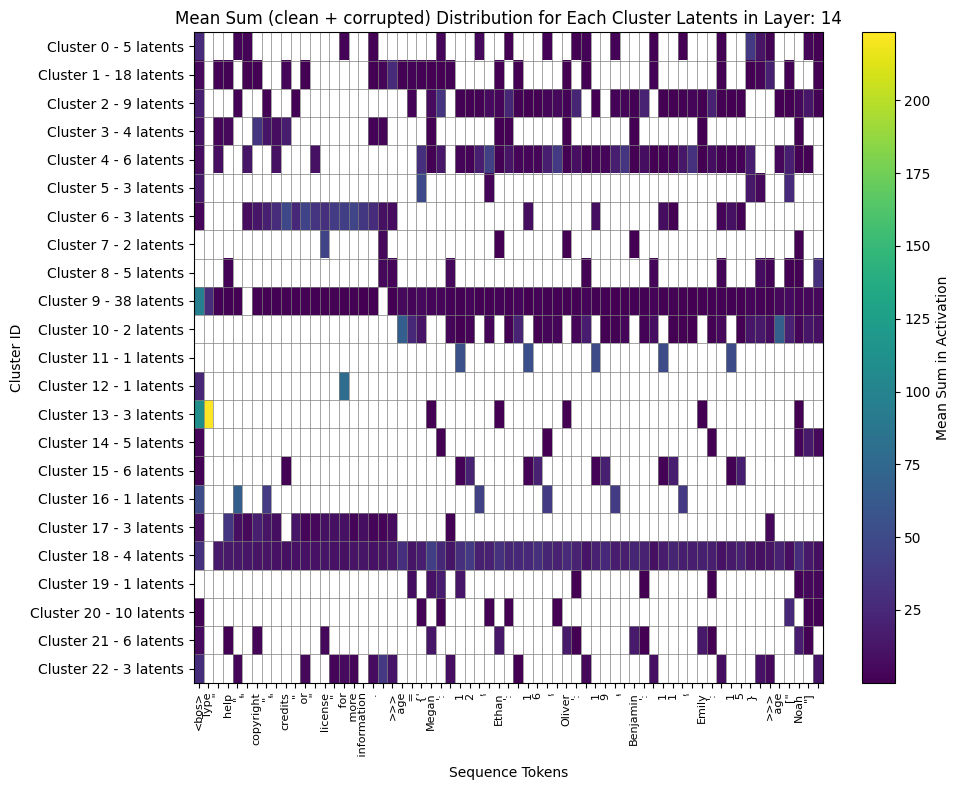

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming `model.to_str_tokens(clean_prompt[0])` provides the token labels for the x-axis
layer_ind = 14
layer = f'blocks.{layer_ind}.hook_resid_post'
combined_vectors_layer = combined_vectors[layer]
diff_vectors_layer = diff_vectors[layer]
sum_vectors_layer = sum_vectors[layer]
clusters = grouped_latents_sum[layer]
tokens = model.to_str_tokens(clean_prompts[0])  # Get token labels for sequence length positions

# Summarization of Mean Difference Distribution for Each Cluster as a Heatmap
cluster_sums = {}
heatmap_data = []
latents_per_cluster = []
for cluster_id in np.unique(clusters):
    # Select diff vectors belonging to the current cluster
    cluster_indices = np.where(clusters == cluster_id)[0]
    cluster_sum_vectors = sum_vectors_layer[cluster_indices]
    latents_per_cluster.append(len(cluster_indices))
    # Calculate the mean difference across latents in this cluster
    cluster_mean_sum = cluster_sum_vectors.mean(dim=0).cpu().numpy()
    cluster_sums[cluster_id] = cluster_mean_sum
    heatmap_data.append(cluster_mean_sum)  # Collect for heatmap plot

# Convert to numpy array for plotting, with each row as a cluster and columns as sequence length positions
heatmap_data = np.array(heatmap_data)

# Create a color map with white for zero values
cmap = plt.cm.viridis
cmap.set_bad(color='white')

# Mask zeros in the heatmap data for white color
masked_heatmap_data = np.ma.masked_where(heatmap_data == 0, heatmap_data)

# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(masked_heatmap_data, aspect='auto', cmap=cmap, interpolation='nearest')
plt.colorbar(label='Mean Sum in Activation')

# Set y-axis to show cluster labels and x-axis to show the last 15 tokens
plt.yticks(ticks=range(len(cluster_sums)), labels=[f'Cluster {i} - {latents_per_cluster[i]} latents' for i in range(len(cluster_sums))])
plt.xticks(ticks=range(len(tokens)), labels=tokens, rotation=90, fontsize=8)  # Reduce x-axis font size to avoid overlap

# Add lines to separate rows and columns
for row in range(1, len(cluster_sums)):
    plt.hlines(row - 0.5, xmin=-0.5, xmax=len(tokens) - 0.5, color='gray', linewidth=0.5)

for col in range(1, len(tokens)):
    plt.vlines(col - 0.5, ymin=-0.5, ymax=len(cluster_sums) - 0.5, color='gray', linewidth=0.5)

# Title and axis labels
plt.title(f'Mean Sum (clean + corrupted) Distribution for Each Cluster Latents in Layer: {layer_ind}')
plt.xlabel('Sequence Tokens')
plt.ylabel('Cluster ID')
plt.tight_layout()
plt.show()

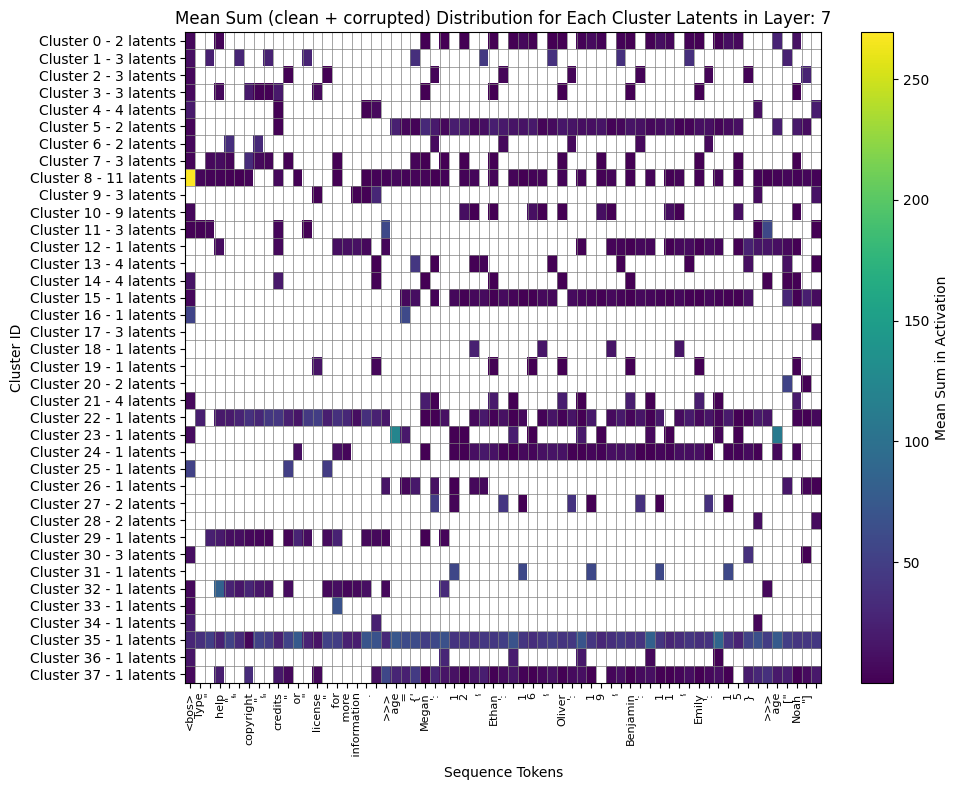

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming `model.to_str_tokens(clean_prompt[0])` provides the token labels for the x-axis
layer_ind = 7
layer = f'blocks.{layer_ind}.hook_resid_post'
combined_vectors_layer = combined_vectors[layer]
diff_vectors_layer = diff_vectors[layer]
sum_vectors_layer = sum_vectors[layer]
clusters = grouped_latents_sum[layer]
tokens = model.to_str_tokens(clean_prompts[0])  # Get token labels for sequence length positions

# Summarization of Mean Difference Distribution for Each Cluster as a Heatmap
cluster_sums = {}
heatmap_data = []
latents_per_cluster = []
for cluster_id in np.unique(clusters):
    # Select diff vectors belonging to the current cluster
    cluster_indices = np.where(clusters == cluster_id)[0]
    cluster_sum_vectors = sum_vectors_layer[cluster_indices]
    latents_per_cluster.append(len(cluster_indices))
    # Calculate the mean difference across latents in this cluster
    cluster_mean_sum = cluster_sum_vectors.mean(dim=0).cpu().numpy()
    cluster_sums[cluster_id] = cluster_mean_sum
    heatmap_data.append(cluster_mean_sum)  # Collect for heatmap plot

# Convert to numpy array for plotting, with each row as a cluster and columns as sequence length positions
heatmap_data = np.array(heatmap_data)

# Create a color map with white for zero values
cmap = plt.cm.viridis
cmap.set_bad(color='white')

# Mask zeros in the heatmap data for white color
masked_heatmap_data = np.ma.masked_where(heatmap_data == 0, heatmap_data)

# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(masked_heatmap_data, aspect='auto', cmap=cmap, interpolation='nearest')
plt.colorbar(label='Mean Sum in Activation')

# Set y-axis to show cluster labels and x-axis to show the last 15 tokens
plt.yticks(ticks=range(len(cluster_sums)), labels=[f'Cluster {i} - {latents_per_cluster[i]} latents' for i in range(len(cluster_sums))])
plt.xticks(ticks=range(len(tokens)), labels=tokens, rotation=90, fontsize=8)  # Reduce x-axis font size to avoid overlap

# Add lines to separate rows and columns
for row in range(1, len(cluster_sums)):
    plt.hlines(row - 0.5, xmin=-0.5, xmax=len(tokens) - 0.5, color='gray', linewidth=0.5)

for col in range(1, len(tokens)):
    plt.vlines(col - 0.5, ymin=-0.5, ymax=len(cluster_sums) - 0.5, color='gray', linewidth=0.5)

# Title and axis labels
plt.title(f'Mean Sum (clean + corrupted) Distribution for Each Cluster Latents in Layer: {layer_ind}')
plt.xlabel('Sequence Tokens')
plt.ylabel('Cluster ID')
plt.tight_layout()
plt.show()

In [30]:
from sklearn.metrics import silhouette_score
import numpy as np

# Range of cluster numbers to try
cluster_range = range(2, 50, 3)
layer = 'blocks.40.hook_resid_post'
best_score = -1
best_n_clusters = 2

# Compute cosine similarity
cos_sim_matrix = cosine_similarity(sum_vectors[layer].cpu().numpy())
distance_matrix = 1 - cos_sim_matrix  # Convert similarity to distance for clustering

# Ensure the diagonal is zero for silhouette_score
np.fill_diagonal(distance_matrix, 0)

# Test different numbers of clusters and calculate silhouette scores
for n_clusters in cluster_range:
    clustering_model = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
    latent_groups = clustering_model.fit_predict(distance_matrix)
    
    # Compute silhouette score
    score = silhouette_score(distance_matrix, latent_groups, metric='precomputed')
    print(f"Silhouette Score for {n_clusters} clusters: {score}")
    # Update best score and number of clusters if improved
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters

print(f"Optimal number of clusters: {best_n_clusters} with silhouette score: {best_score}")

Silhouette Score for 2 clusters: 0.16430477797985077
Silhouette Score for 5 clusters: 0.17563611268997192
Silhouette Score for 8 clusters: 0.17563611268997192
Silhouette Score for 11 clusters: 0.185194194316864
Silhouette Score for 14 clusters: 0.21767981350421906
Silhouette Score for 17 clusters: 0.2347404658794403
Silhouette Score for 20 clusters: 0.3001585900783539
Silhouette Score for 23 clusters: 0.29967084527015686
Silhouette Score for 26 clusters: 0.3462952971458435
Silhouette Score for 29 clusters: 0.3580603003501892
Silhouette Score for 32 clusters: 0.3824283480644226
Silhouette Score for 35 clusters: 0.43204444646835327
Silhouette Score for 38 clusters: 0.42382562160491943
Silhouette Score for 41 clusters: 0.4042615294456482
Silhouette Score for 44 clusters: 0.3887978792190552
Silhouette Score for 47 clusters: 0.386697918176651
Optimal number of clusters: 35 with silhouette score: 0.43204444646835327


In [31]:
latent_n_clusters = {'blocks.40.hook_resid_post': 35, 'blocks.21.hook_resid_post': 26, 'blocks.14.hook_resid_post': 23, 'blocks.7.hook_resid_post': 38}
grouped_latents_sum = {}
for layer in mask.keys():
    # Compute cosine similarity for combined vectors
    cos_sim_matrix = cosine_similarity(sum_vectors[layer].cpu().numpy())
    
    # 5. Apply clustering (Agglomerative Clustering) based on cosine similarity
    clustering_model = AgglomerativeClustering(n_clusters=latent_n_clusters[layer], metric='precomputed', linkage='average')
    latent_groups = clustering_model.fit_predict(1 - cos_sim_matrix)  # 1 - cosine similarity as a distance measure
    
    # Store the group labels for each latent in this layer
    grouped_latents_sum[layer] = latent_groups

# Now `grouped_latents` contains clusters for each latent in each layer based on clean/corrupted vectors.
print(grouped_latents_sum)

{'blocks.7.hook_resid_post': array([35, 30, 34,  4,  4,  5,  1,  4,  2,  8,  8, 14,  9,  3,  6, 10, 37,
        8, 14, 13,  5, 17,  2, 36, 10, 11, 13, 10, 31, 22,  8,  2, 14, 28,
       17, 20,  8, 10,  8,  8, 27,  8, 10,  4,  3, 26, 13, 10, 10, 21, 14,
       25,  7,  9, 10, 12,  3,  8, 19,  0, 28, 21,  9,  0, 11, 23, 11, 27,
        1, 20, 24, 13, 21,  6, 29,  1, 21, 33, 17,  8, 32, 30, 30,  7,  8,
       15, 16, 10,  7, 18]), 'blocks.14.hook_resid_post': array([ 7,  6, 14, 13,  9,  8,  2, 20, 20, 17,  1,  1,  9,  3,  9,  9,  1,
        8,  2,  1,  9, 14,  1,  9,  5, 15,  2,  2,  1,  9, 20,  1,  9,  9,
        9, 21, 19,  1,  4, 18, 20,  9,  4, 21, 16, 15,  2,  0,  2, 22,  3,
        5,  4,  8,  9, 22,  1,  9, 14,  7,  0,  2,  9,  9, 18,  9,  9, 17,
       10,  4,  6,  9,  9, 15,  9,  8, 18,  1, 21,  1, 20,  9,  1,  1,  1,
        9, 20,  9,  3,  9,  9, 18, 20, 13,  3,  2,  1,  4, 11, 20, 12,  1,
        9,  4,  0,  9,  9,  9,  9,  0,  1, 21,  9,  8, 15, 20,  9,  9, 15,
        0, 22

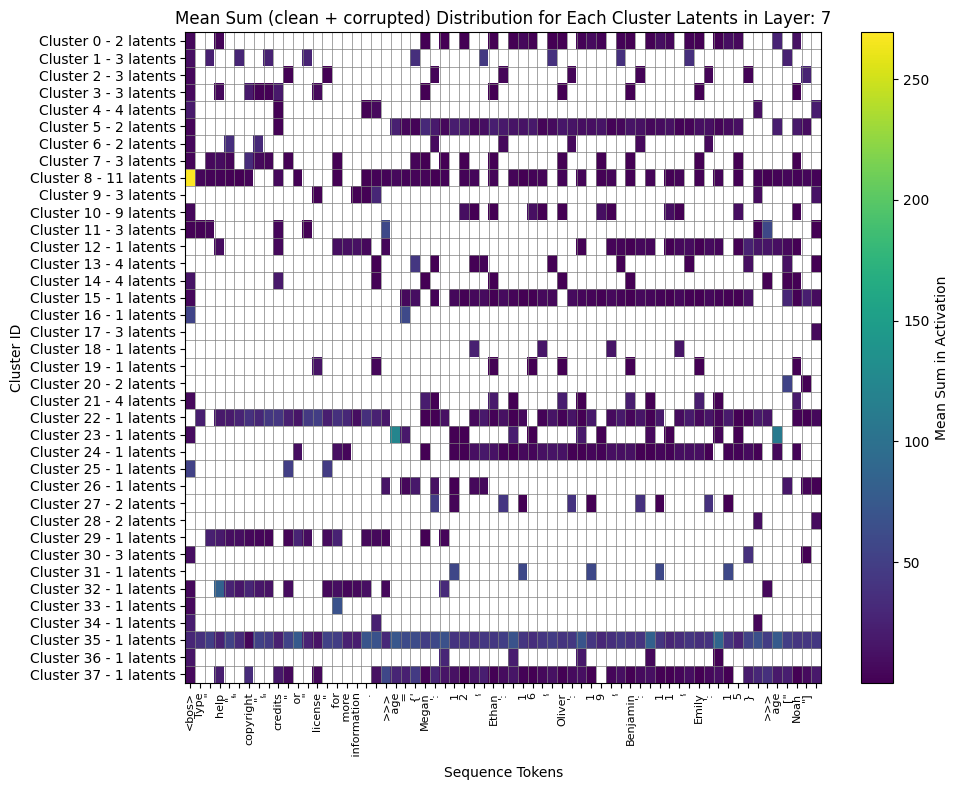

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming `model.to_str_tokens(clean_prompt[0])` provides the token labels for the x-axis
layer_ind = 7
layer = f'blocks.{layer_ind}.hook_resid_post'
combined_vectors_layer = combined_vectors[layer]
diff_vectors_layer = diff_vectors[layer]
sum_vectors_layer = sum_vectors[layer]
clusters = grouped_latents_sum[layer]
tokens = model.to_str_tokens(clean_prompts[0])  # Get token labels for sequence length positions

# Summarization of Mean Difference Distribution for Each Cluster as a Heatmap
cluster_sums = {}
heatmap_data = []
latents_per_cluster = []
for cluster_id in np.unique(clusters):
    # Select diff vectors belonging to the current cluster
    cluster_indices = np.where(clusters == cluster_id)[0]
    cluster_sum_vectors = sum_vectors_layer[cluster_indices]
    latents_per_cluster.append(len(cluster_indices))
    # Calculate the mean difference across latents in this cluster
    cluster_mean_sum = cluster_sum_vectors.mean(dim=0).cpu().numpy()
    cluster_sums[cluster_id] = cluster_mean_sum
    heatmap_data.append(cluster_mean_sum)  # Collect for heatmap plot

# Convert to numpy array for plotting, with each row as a cluster and columns as sequence length positions
heatmap_data = np.array(heatmap_data)

# Create a color map with white for zero values
cmap = plt.cm.viridis
cmap.set_bad(color='white')

# Mask zeros in the heatmap data for white color
masked_heatmap_data = np.ma.masked_where(heatmap_data == 0, heatmap_data)

# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(masked_heatmap_data, aspect='auto', cmap=cmap, interpolation='nearest')
plt.colorbar(label='Mean Sum in Activation')

# Set y-axis to show cluster labels and x-axis to show the last 15 tokens
plt.yticks(ticks=range(len(cluster_sums)), labels=[f'Cluster {i} - {latents_per_cluster[i]} latents' for i in range(len(cluster_sums))])
plt.xticks(ticks=range(len(tokens)), labels=tokens, rotation=90, fontsize=8)  # Reduce x-axis font size to avoid overlap

# Add lines to separate rows and columns
for row in range(1, len(cluster_sums)):
    plt.hlines(row - 0.5, xmin=-0.5, xmax=len(tokens) - 0.5, color='gray', linewidth=0.5)

for col in range(1, len(tokens)):
    plt.vlines(col - 0.5, ymin=-0.5, ymax=len(cluster_sums) - 0.5, color='gray', linewidth=0.5)

# Title and axis labels
plt.title(f'Mean Sum (clean + corrupted) Distribution for Each Cluster Latents in Layer: {layer_ind}')
plt.xlabel('Sequence Tokens')
plt.ylabel('Cluster ID')
plt.tight_layout()
plt.show()

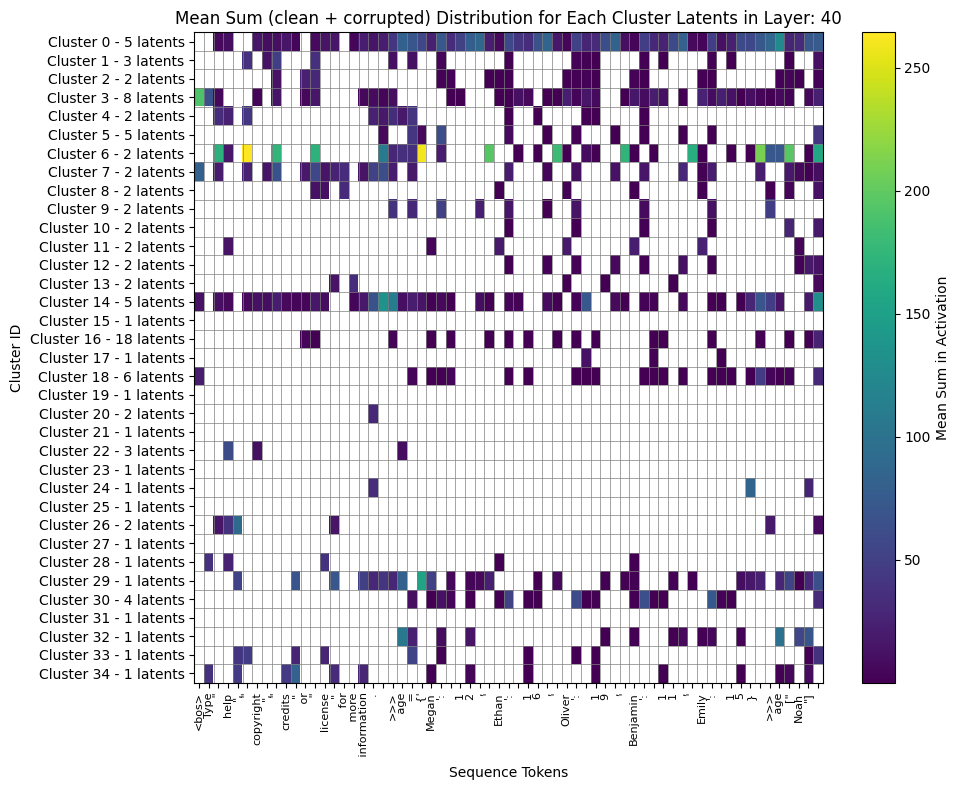

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming `model.to_str_tokens(clean_prompt[0])` provides the token labels for the x-axis
layer_ind = 40
layer = f'blocks.{layer_ind}.hook_resid_post'
combined_vectors_layer = combined_vectors[layer]
diff_vectors_layer = diff_vectors[layer]
sum_vectors_layer = sum_vectors[layer]
clusters = grouped_latents_sum[layer]
tokens = model.to_str_tokens(clean_prompts[0])  # Get token labels for sequence length positions

# Summarization of Mean Difference Distribution for Each Cluster as a Heatmap
cluster_sums = {}
heatmap_data = []
latents_per_cluster = []
for cluster_id in np.unique(clusters):
    # Select diff vectors belonging to the current cluster
    cluster_indices = np.where(clusters == cluster_id)[0]
    cluster_sum_vectors = sum_vectors_layer[cluster_indices]
    latents_per_cluster.append(len(cluster_indices))
    # Calculate the mean difference across latents in this cluster
    cluster_mean_sum = cluster_sum_vectors.mean(dim=0).cpu().numpy()
    cluster_sums[cluster_id] = cluster_mean_sum
    heatmap_data.append(cluster_mean_sum)  # Collect for heatmap plot

# Convert to numpy array for plotting, with each row as a cluster and columns as sequence length positions
heatmap_data = np.array(heatmap_data)

# Create a color map with white for zero values
cmap = plt.cm.viridis
cmap.set_bad(color='white')

# Mask zeros in the heatmap data for white color
masked_heatmap_data = np.ma.masked_where(heatmap_data == 0, heatmap_data)

# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(masked_heatmap_data, aspect='auto', cmap=cmap, interpolation='nearest')
plt.colorbar(label='Mean Sum in Activation')

# Set y-axis to show cluster labels and x-axis to show the last 15 tokens
plt.yticks(ticks=range(len(cluster_sums)), labels=[f'Cluster {i} - {latents_per_cluster[i]} latents' for i in range(len(cluster_sums))])
plt.xticks(ticks=range(len(tokens)), labels=tokens, rotation=90, fontsize=8)  # Reduce x-axis font size to avoid overlap

# Add lines to separate rows and columns
for row in range(1, len(cluster_sums)):
    plt.hlines(row - 0.5, xmin=-0.5, xmax=len(tokens) - 0.5, color='gray', linewidth=0.5)

for col in range(1, len(tokens)):
    plt.vlines(col - 0.5, ymin=-0.5, ymax=len(cluster_sums) - 0.5, color='gray', linewidth=0.5)

# Title and axis labels
plt.title(f'Mean Sum (clean + corrupted) Distribution for Each Cluster Latents in Layer: {layer_ind}')
plt.xlabel('Sequence Tokens')
plt.ylabel('Cluster ID')
plt.tight_layout()
plt.show()

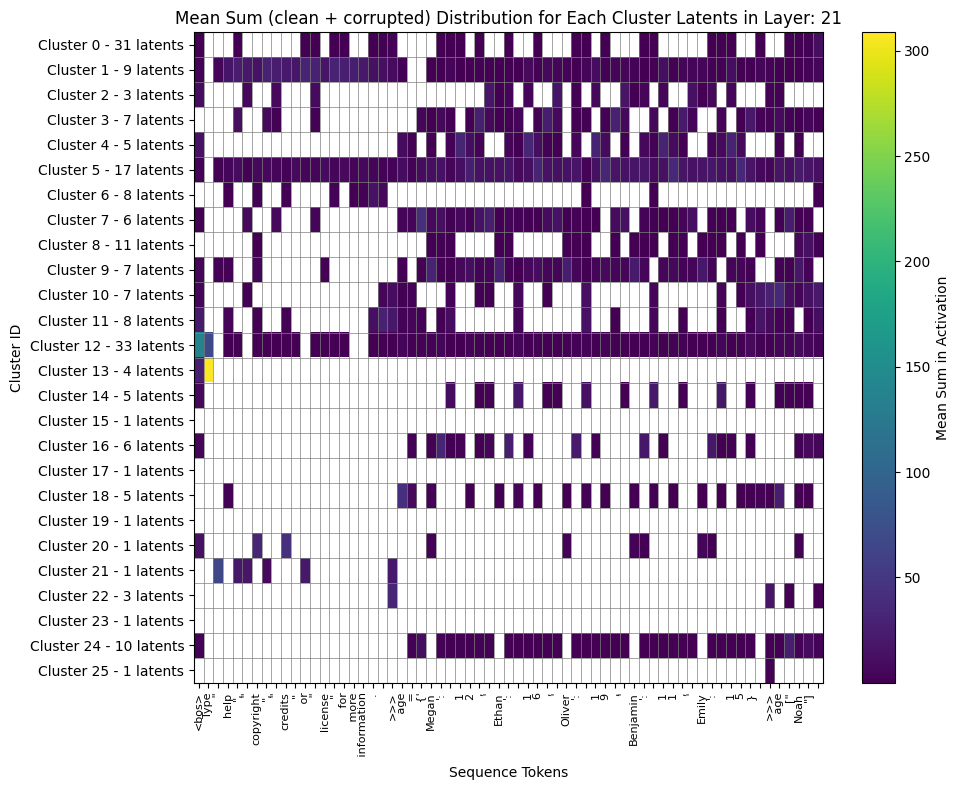

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming `model.to_str_tokens(clean_prompt[0])` provides the token labels for the x-axis
layer_ind = 21
layer = f'blocks.{layer_ind}.hook_resid_post'
combined_vectors_layer = combined_vectors[layer]
diff_vectors_layer = diff_vectors[layer]
sum_vectors_layer = sum_vectors[layer]
clusters = grouped_latents_sum[layer]
tokens = model.to_str_tokens(clean_prompts[0])  # Get token labels for sequence length positions

# Summarization of Mean Difference Distribution for Each Cluster as a Heatmap
cluster_sums = {}
heatmap_data = []
latents_per_cluster = []
for cluster_id in np.unique(clusters):
    # Select diff vectors belonging to the current cluster
    cluster_indices = np.where(clusters == cluster_id)[0]
    cluster_sum_vectors = sum_vectors_layer[cluster_indices]
    latents_per_cluster.append(len(cluster_indices))
    # Calculate the mean difference across latents in this cluster
    cluster_mean_sum = cluster_sum_vectors.mean(dim=0).cpu().numpy()
    cluster_sums[cluster_id] = cluster_mean_sum
    heatmap_data.append(cluster_mean_sum)  # Collect for heatmap plot

# Convert to numpy array for plotting, with each row as a cluster and columns as sequence length positions
heatmap_data = np.array(heatmap_data)

# Create a color map with white for zero values
cmap = plt.cm.viridis
cmap.set_bad(color='white')

# Mask zeros in the heatmap data for white color
masked_heatmap_data = np.ma.masked_where(heatmap_data == 0, heatmap_data)

# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(masked_heatmap_data, aspect='auto', cmap=cmap, interpolation='nearest')
plt.colorbar(label='Mean Sum in Activation')

# Set y-axis to show cluster labels and x-axis to show the last 15 tokens
plt.yticks(ticks=range(len(cluster_sums)), labels=[f'Cluster {i} - {latents_per_cluster[i]} latents' for i in range(len(cluster_sums))])
plt.xticks(ticks=range(len(tokens)), labels=tokens, rotation=90, fontsize=8)  # Reduce x-axis font size to avoid overlap

# Add lines to separate rows and columns
for row in range(1, len(cluster_sums)):
    plt.hlines(row - 0.5, xmin=-0.5, xmax=len(tokens) - 0.5, color='gray', linewidth=0.5)

for col in range(1, len(tokens)):
    plt.vlines(col - 0.5, ymin=-0.5, ymax=len(cluster_sums) - 0.5, color='gray', linewidth=0.5)

# Title and axis labels
plt.title(f'Mean Sum (clean + corrupted) Distribution for Each Cluster Latents in Layer: {layer_ind}')
plt.xlabel('Sequence Tokens')
plt.ylabel('Cluster ID')
plt.tight_layout()
plt.show()

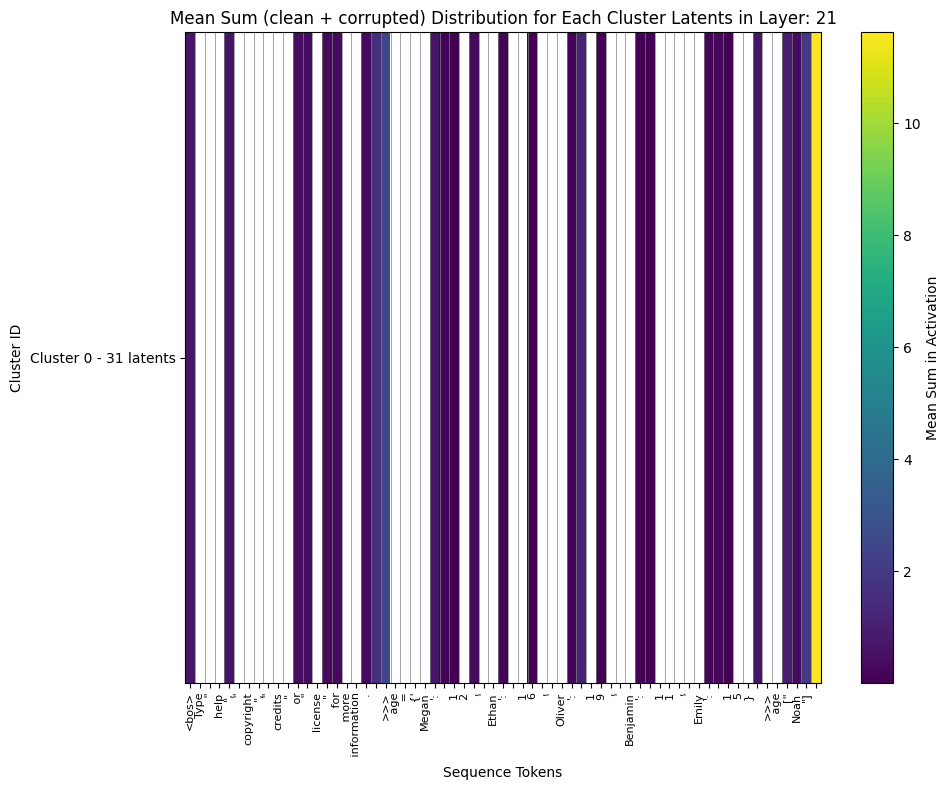

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming `model.to_str_tokens(clean_prompt[0])` provides the token labels for the x-axis
layer_ind = 21
layer = f'blocks.{layer_ind}.hook_resid_post'
combined_vectors_layer = combined_vectors[layer]
diff_vectors_layer = diff_vectors[layer]
sum_vectors_layer = sum_vectors[layer]
clusters = grouped_latents_sum[layer]
tokens = model.to_str_tokens(clean_prompts[0])  # Get token labels for sequence length positions

# Summarization of Mean Difference Distribution for Each Cluster as a Heatmap
cluster_sums = {}
heatmap_data = []
latents_per_cluster = []
for cluster_id in np.unique(clusters):
    if cluster_id != 0:
        continue
    # Select diff vectors belonging to the current cluster
    cluster_indices = np.where(clusters == cluster_id)[0]
    cluster_sum_vectors = sum_vectors_layer[cluster_indices]
    latents_per_cluster.append(len(cluster_indices))
    # Calculate the mean difference across latents in this cluster
    cluster_mean_sum = cluster_sum_vectors.mean(dim=0).cpu().numpy()
    cluster_sums[cluster_id] = cluster_mean_sum
    heatmap_data.append(cluster_mean_sum)  # Collect for heatmap plot

# Convert to numpy array for plotting, with each row as a cluster and columns as sequence length positions
heatmap_data = np.array(heatmap_data)

# Create a color map with white for zero values
cmap = plt.cm.viridis
cmap.set_bad(color='white')

# Mask zeros in the heatmap data for white color
masked_heatmap_data = np.ma.masked_where(heatmap_data == 0, heatmap_data)

# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(masked_heatmap_data, aspect='auto', cmap=cmap, interpolation='nearest')
plt.colorbar(label='Mean Sum in Activation')

# Set y-axis to show cluster labels and x-axis to show the last 15 tokens
plt.yticks(ticks=range(len(cluster_sums)), labels=[f'Cluster {i} - {latents_per_cluster[i]} latents' for i in range(len(cluster_sums))])
plt.xticks(ticks=range(len(tokens)), labels=tokens, rotation=90, fontsize=8)  # Reduce x-axis font size to avoid overlap

# Add lines to separate rows and columns
for row in range(1, len(cluster_sums)):
    plt.hlines(row - 0.5, xmin=-0.5, xmax=len(tokens) - 0.5, color='gray', linewidth=0.5)

for col in range(1, len(tokens)):
    plt.vlines(col - 0.5, ymin=-0.5, ymax=len(cluster_sums) - 0.5, color='gray', linewidth=0.5)

# Title and axis labels
plt.title(f'Mean Sum (clean + corrupted) Distribution for Each Cluster Latents in Layer: {layer_ind}')
plt.xlabel('Sequence Tokens')
plt.ylabel('Cluster ID')
plt.tight_layout()
plt.show()

In [36]:
clean_prompts[0]

'Type "help", "copyright", "credits" or "license" for more information.\n>>> age = {\'Megan\': 12, \'Ethan\': 16, \'Oliver\': 19, \'Benjamin\': 11, \'Emily\': 15}\n>>> age["Noah"]\n'

In [37]:
print(clean_prompts[0])

Type "help", "copyright", "credits" or "license" for more information.
>>> age = {'Megan': 12, 'Ethan': 16, 'Oliver': 19, 'Benjamin': 11, 'Emily': 15}
>>> age["Noah"]



In [38]:
from collections import defaultdict

# Initialize a dictionary to hold lists of latent indices for each cluster
cluster_latent_indices = defaultdict(list)

# Iterate over each latent index and its assigned cluster
for idx, cluster_id in enumerate(clusters):
    # Append the index of the latent to the appropriate cluster list
    cluster_latent_indices[cluster_id].append(mask[layer][idx])

# Print the latent indices for each cluster
for cluster_id, indices in cluster_latent_indices.items():
    print(f"Cluster {cluster_id}: Latent Indices: {indices}")

Cluster 6: Latent Indices: [13, 2899, 11248, 11904, 12008, 12891, 13463, 14347]
Cluster 12: Latent Indices: [43, 712, 718, 918, 2054, 2442, 2445, 3492, 4312, 4570, 4643, 4737, 4781, 4784, 4964, 5159, 5833, 7015, 8781, 9372, 9398, 9663, 10330, 11586, 12340, 12797, 14369, 14377, 14638, 15332, 15689, 15786, 16165]
Cluster 0: Latent Indices: [52, 406, 722, 1408, 1662, 1723, 1744, 1831, 2123, 2739, 3023, 3547, 4636, 4926, 5108, 6650, 7272, 8082, 8127, 8853, 10236, 10488, 12029, 12314, 12987, 13459, 13774, 13902, 15393, 15609, 15881]
Cluster 5: Latent Indices: [520, 2239, 3018, 6786, 7024, 7414, 7599, 8085, 8732, 10996, 12440, 12490, 15068, 15178, 15278, 15470, 15954]
Cluster 8: Latent Indices: [534, 2957, 3076, 7216, 8255, 8615, 9412, 9662, 11455, 12557, 13626]
Cluster 11: Latent Indices: [576, 3377, 4333, 4541, 9797, 10362, 11451, 12890]
Cluster 19: Latent Indices: [824]
Cluster 9: Latent Indices: [1374, 2919, 7675, 8398, 10454, 15598, 15616]
Cluster 16: Latent Indices: [1942, 1967, 5219, 

In [39]:
latent_n_clusters = {'blocks.40.hook_resid_post': 35, 'blocks.21.hook_resid_post': 26, 'blocks.14.hook_resid_post': 23, 'blocks.7.hook_resid_post': 38}
grouped_latents_diff = {}
for layer in mask.keys():
    # Compute cosine similarity for combined vectors
    cos_sim_matrix = cosine_similarity(diff_vectors[layer].cpu().numpy())
    
    # 5. Apply clustering (Agglomerative Clustering) based on cosine similarity
    clustering_model = AgglomerativeClustering(n_clusters=latent_n_clusters[layer], metric='precomputed', linkage='average')
    latent_groups = clustering_model.fit_predict(1 - cos_sim_matrix)  # 1 - cosine similarity as a distance measure
    
    # Store the group labels for each latent in this layer
    grouped_latents_diff[layer] = latent_groups

# Now `grouped_latents` contains clusters for each latent in each layer based on clean/corrupted vectors.
print(grouped_latents_diff)

{'blocks.7.hook_resid_post': array([ 1,  0,  0,  2,  4,  1,  0,  2,  3,  0,  0,  2,  4,  1,  0,  0,  1,
        2,  0,  0,  1,  4,  3,  0,  1,  4, 37, 36, 35,  4, 34,  1, 33,  4,
        4,  3, 32, 31,  2,  2, 30, 29, 28,  4, 27,  1,  2, 26, 25,  2,  2,
       24, 23,  2, 22,  2,  2,  1,  2,  1,  4,  1,  4,  1, 21, 20, 19, 18,
       17, 16,  2, 15,  2, 14, 13, 12,  2, 11,  4,  3,  9,  8,  3,  2,  7,
        3,  6,  5,  1, 10]), 'blocks.14.hook_resid_post': array([ 4,  0,  2,  0,  0,  1,  2,  0,  0,  0,  0,  0,  2,  1,  0,  2,  0,
        1,  2,  0,  1,  1,  2,  0,  0,  0,  2,  2,  0,  2,  1,  0,  1,  2,
        2,  1,  1,  0,  0,  2,  0,  0,  0,  4,  0,  0,  1,  0,  1,  0,  0,
        0,  1,  1,  0,  2,  0,  1,  2,  0,  0,  2,  1,  0,  2,  0,  1,  0,
        0,  0,  0,  1,  1,  0,  0,  2,  1,  0,  4,  0,  1,  2,  0,  0,  0,
        2,  1,  0,  0,  0,  1,  2,  0,  1,  0,  0, 22,  1, 21, 20, 19, 18,
        1,  2, 17,  1,  1,  1, 16, 15, 14,  1,  1,  1, 13,  1,  2,  1, 12,
        2,  2

In [40]:
latent_n_clusters = {'blocks.40.hook_resid_post': 3, 'blocks.21.hook_resid_post': 2, 'blocks.14.hook_resid_post': 3, 'blocks.7.hook_resid_post': 5}
grouped_latents_diff = {}
for layer in mask.keys():
    # Compute cosine similarity for combined vectors
    cos_sim_matrix = cosine_similarity(diff_vectors[layer].cpu().numpy())
    
    # 5. Apply clustering (Agglomerative Clustering) based on cosine similarity
    clustering_model = AgglomerativeClustering(n_clusters=latent_n_clusters[layer], metric='precomputed', linkage='average')
    latent_groups = clustering_model.fit_predict(1 - cos_sim_matrix)  # 1 - cosine similarity as a distance measure
    
    # Store the group labels for each latent in this layer
    grouped_latents_diff[layer] = latent_groups

# Now `grouped_latents` contains clusters for each latent in each layer based on clean/corrupted vectors.
print(grouped_latents_diff)

{'blocks.7.hook_resid_post': array([1, 0, 0, 2, 0, 1, 0, 2, 3, 0, 0, 2, 0, 1, 0, 0, 1, 2, 0, 0, 1, 0,
       3, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 2, 2, 0, 0, 0, 0,
       0, 1, 2, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 1, 2, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 3, 0, 0, 3, 2, 0, 3, 2, 0,
       1, 4]), 'blocks.14.hook_resid_post': array([0, 0, 2, 0, 0, 1, 2, 0, 0, 0, 0, 0, 2, 1, 0, 2, 0, 1, 2, 0, 1, 1,
       2, 0, 0, 0, 2, 2, 0, 2, 1, 0, 1, 2, 2, 1, 1, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 2, 0, 1, 2, 0, 0, 2, 1, 0, 2, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 2, 1, 0, 0, 0, 1, 2, 0, 0, 0, 2, 1, 0,
       0, 0, 1, 2, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 2, 1, 0, 2, 2, 0, 2, 0, 1, 0, 1, 0, 1, 2, 0, 0,
       0, 0, 2, 0, 2, 0, 1]), 'blocks.21.hook_resid_post': array([0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0

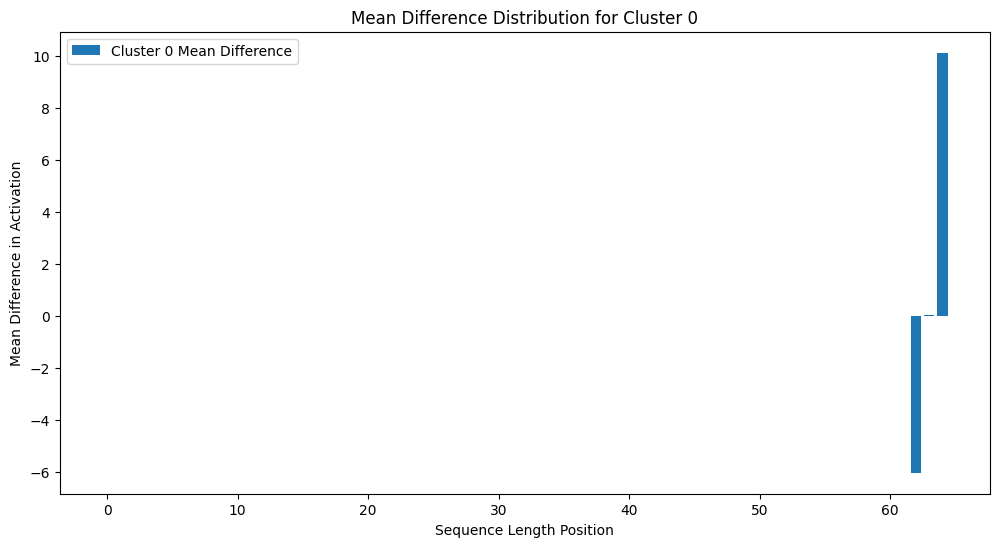

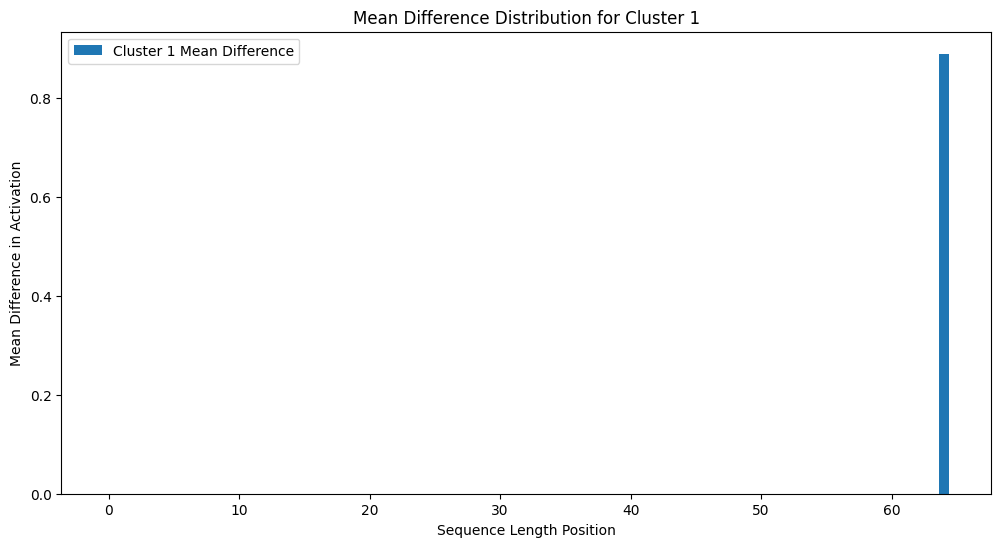

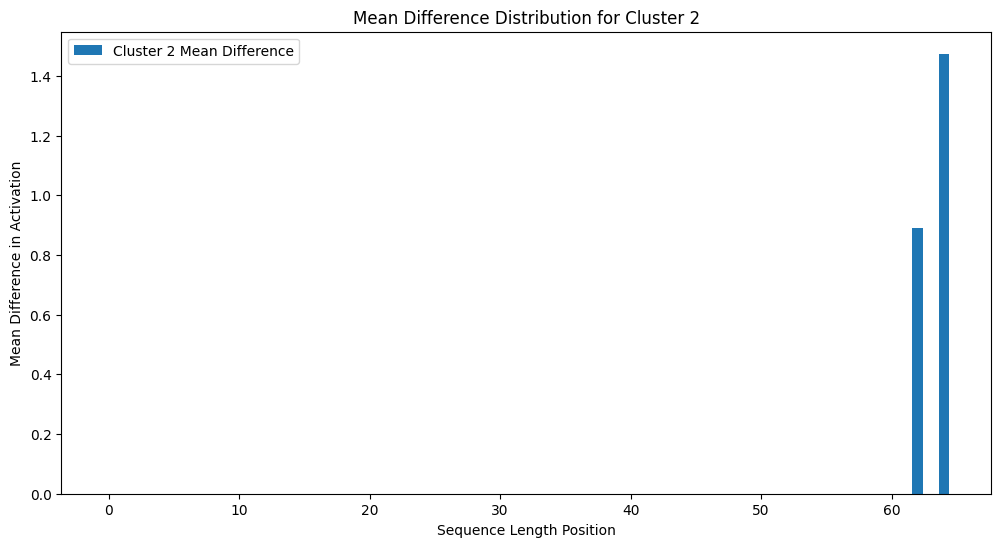

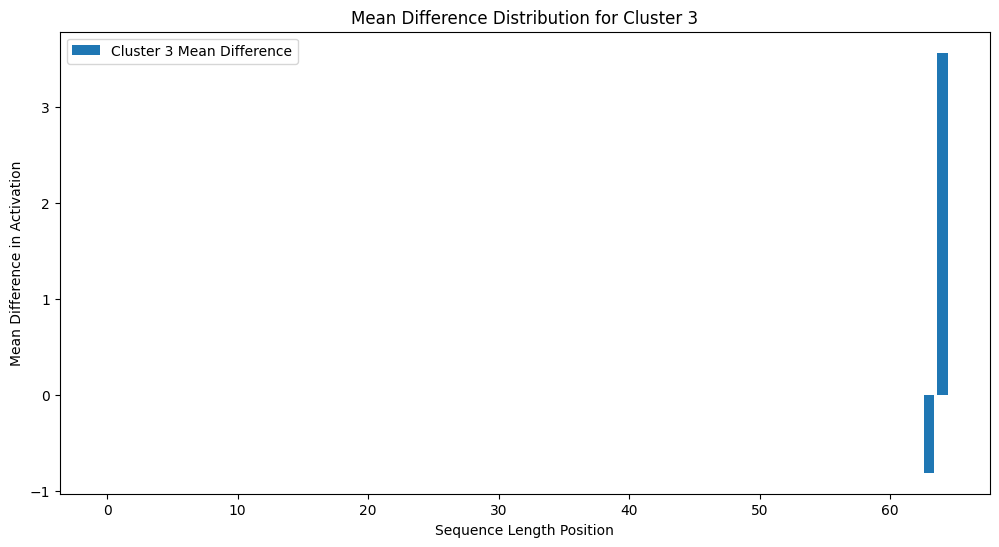

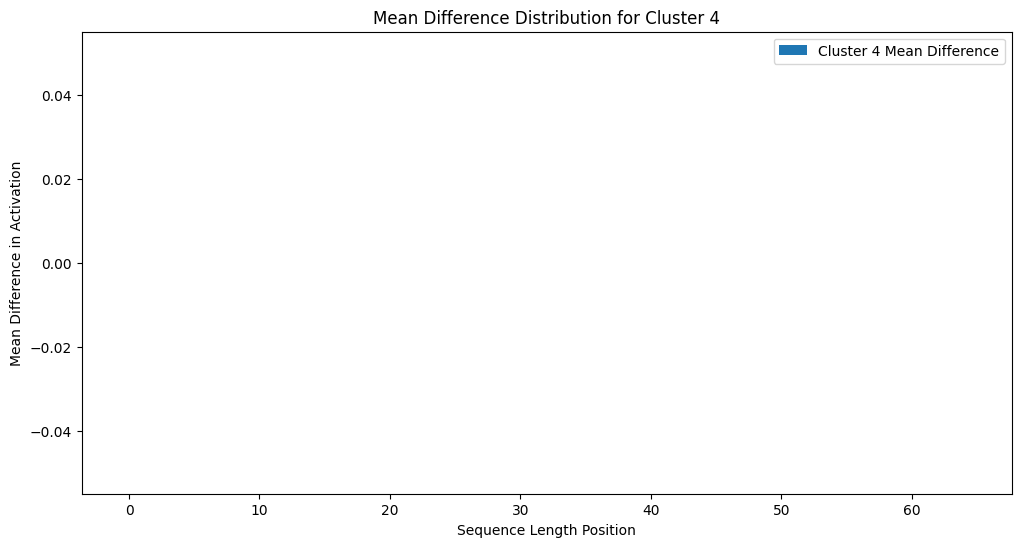

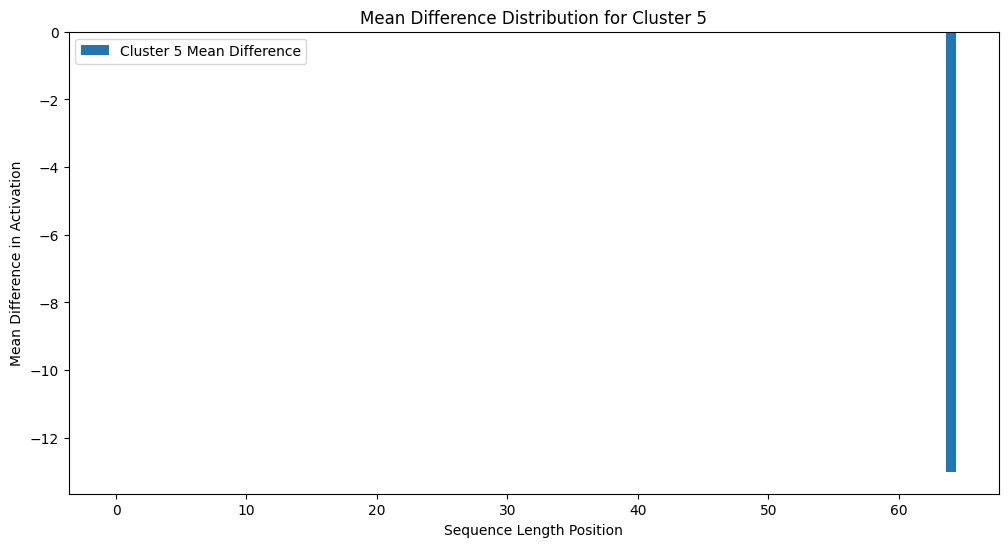

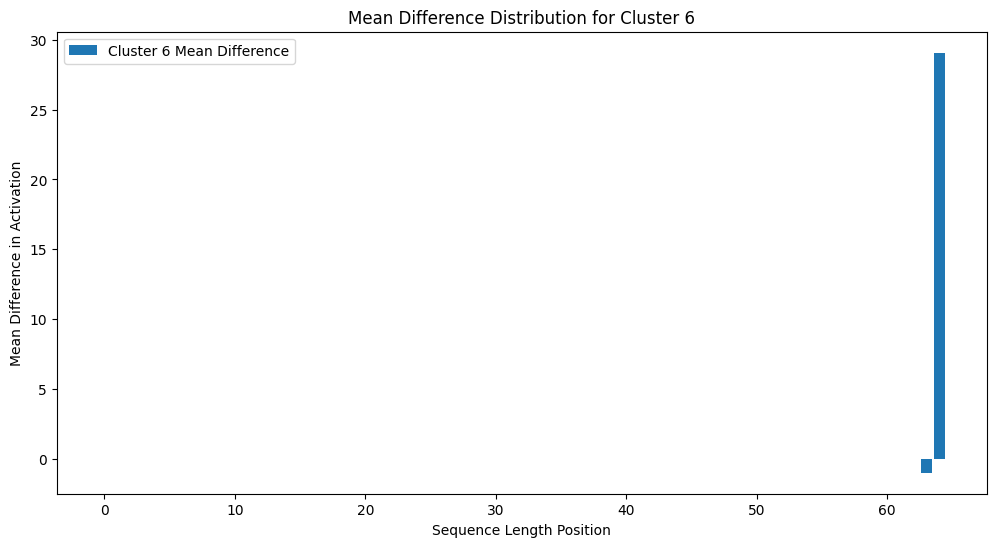

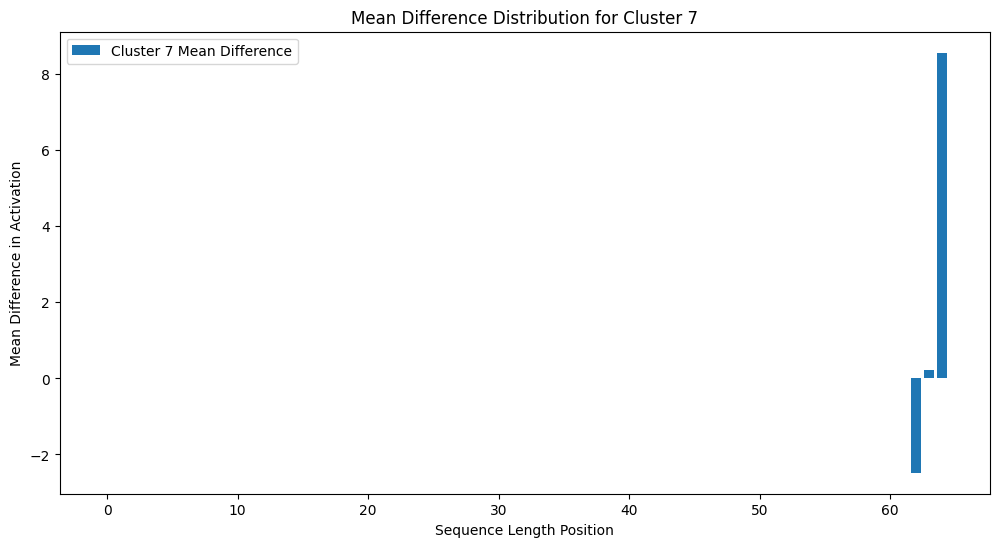

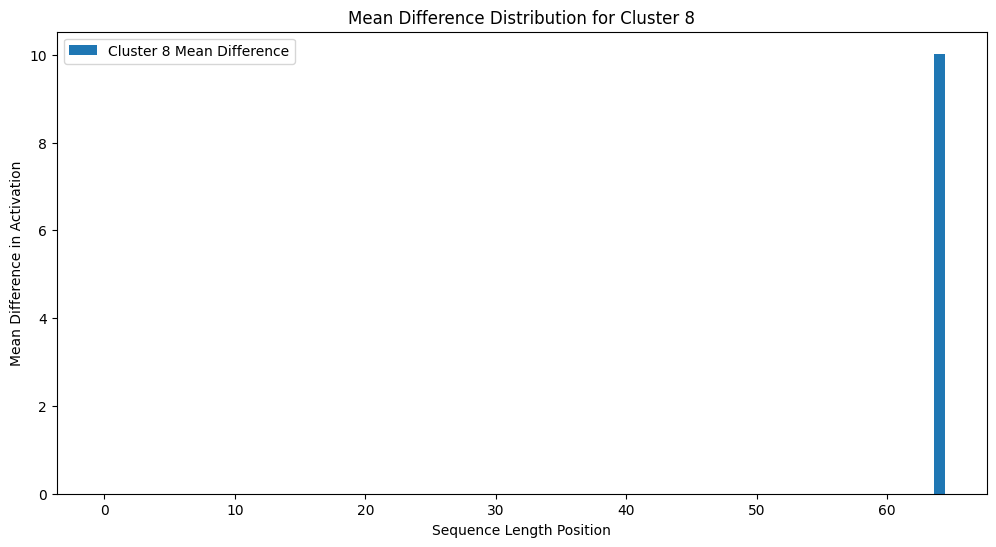

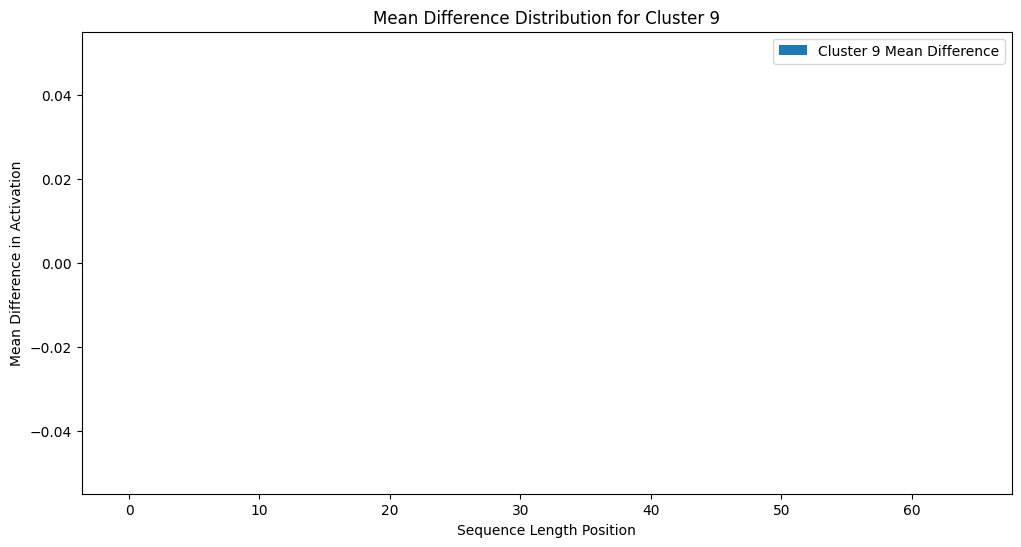

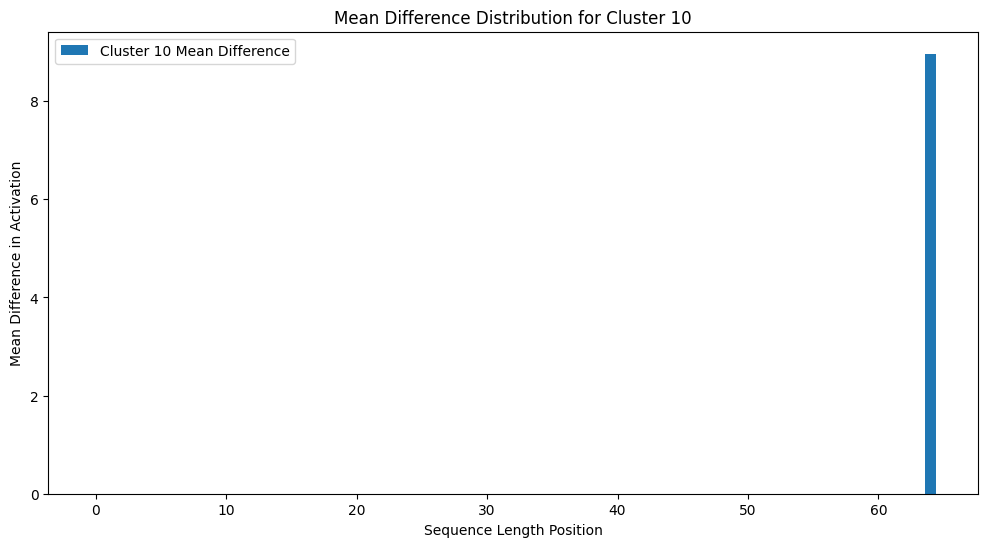

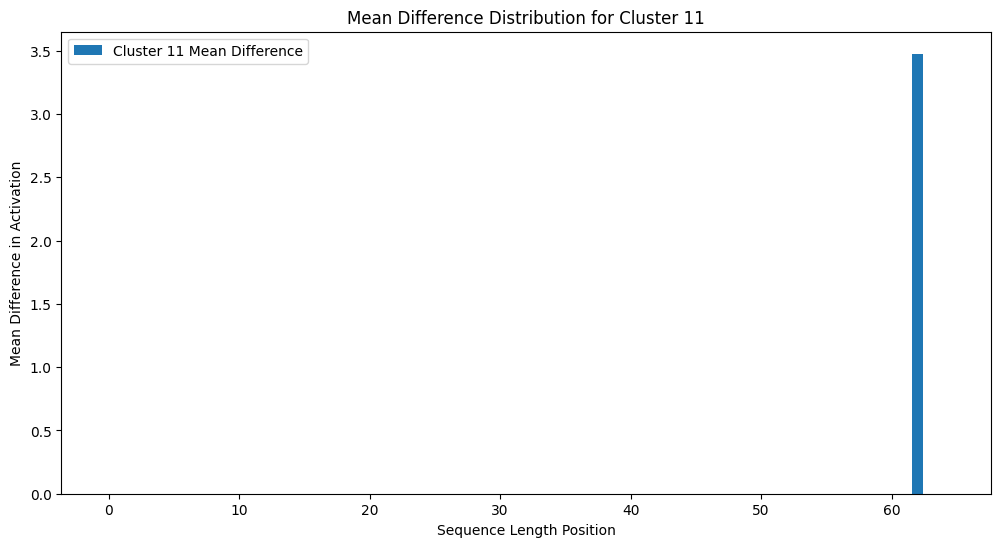

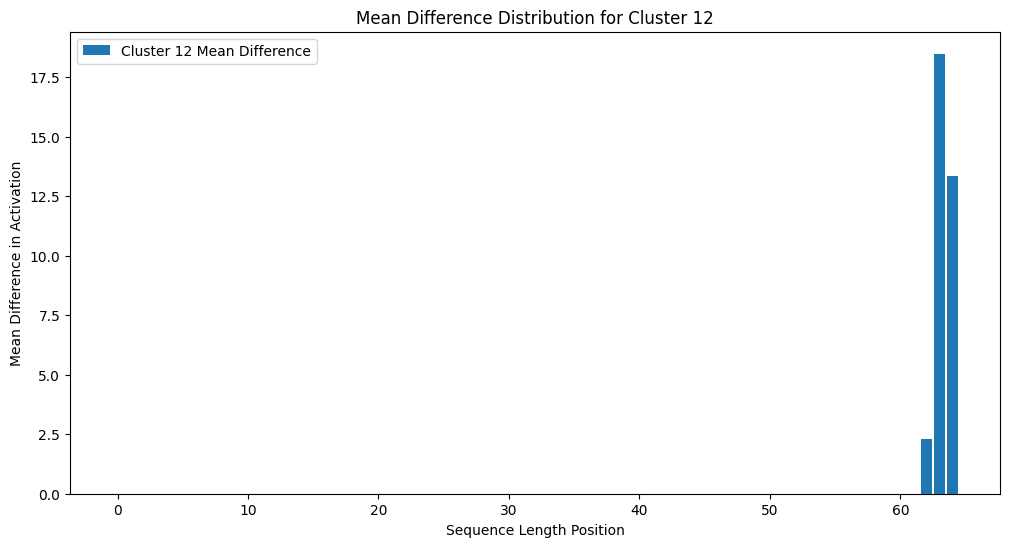

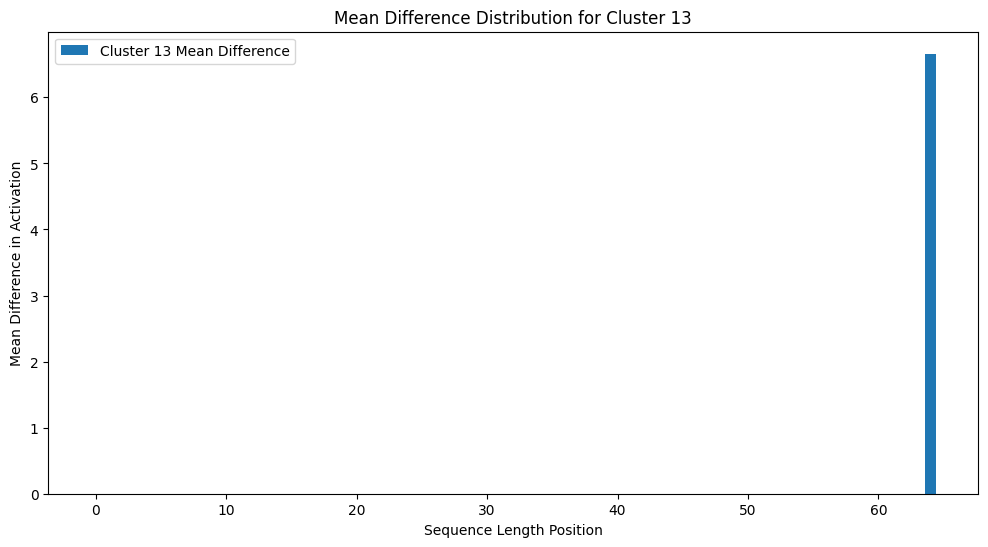

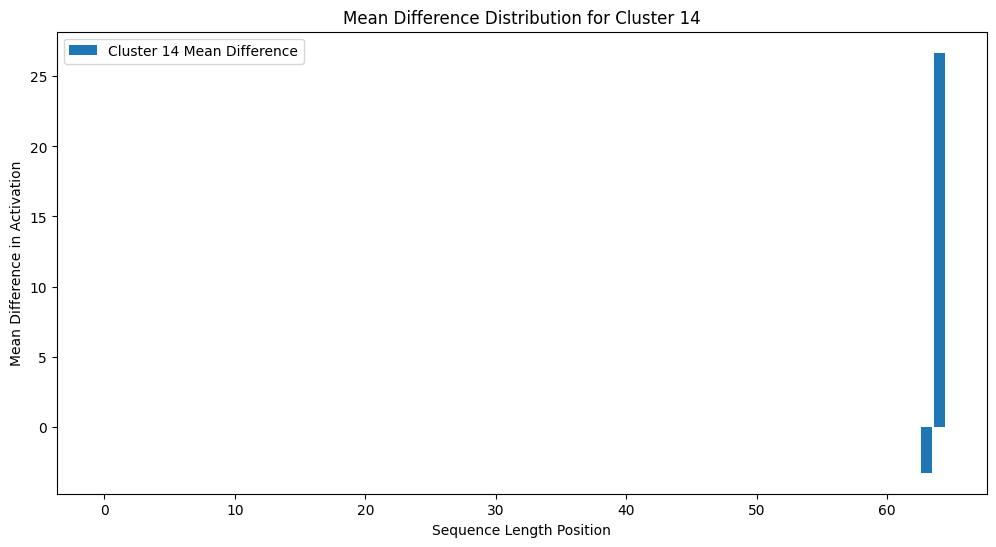

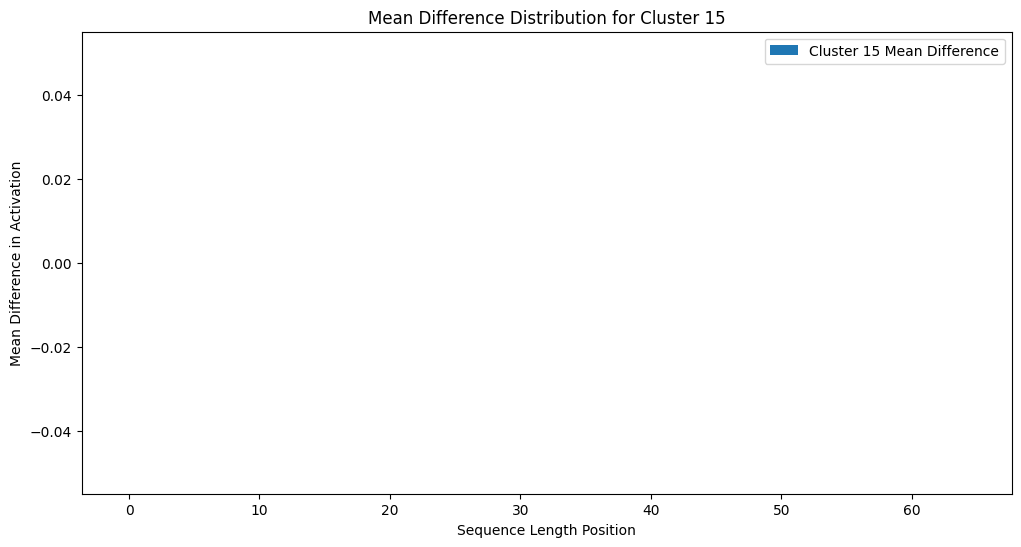

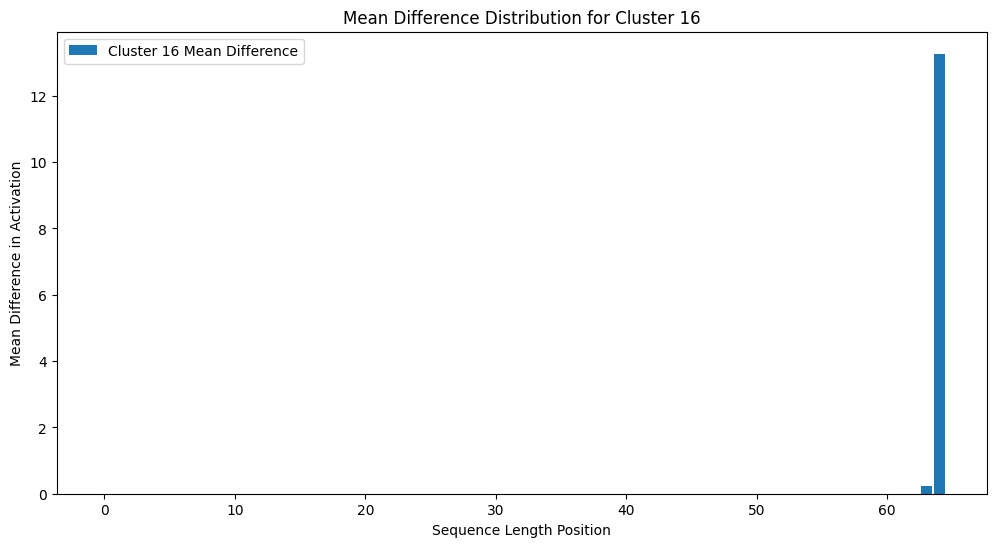

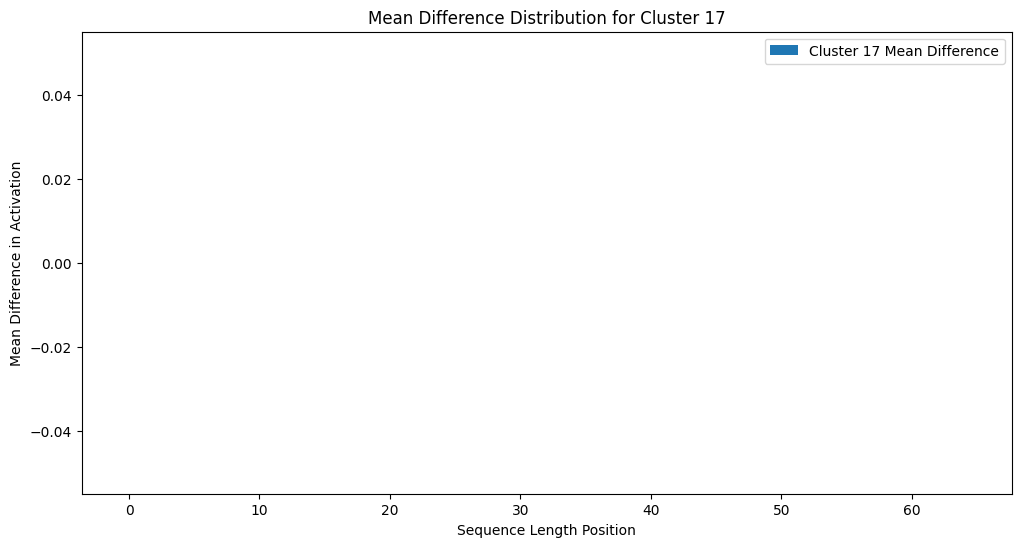

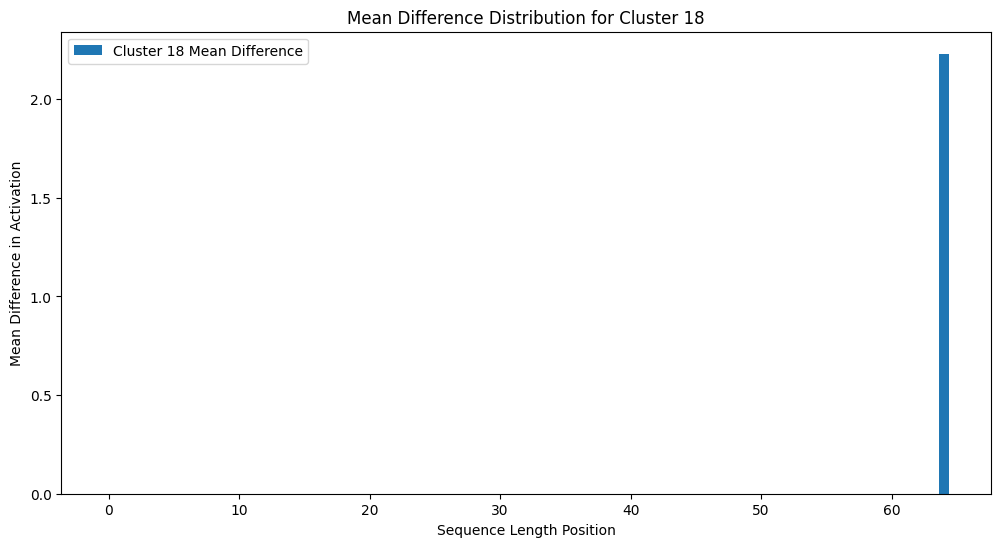

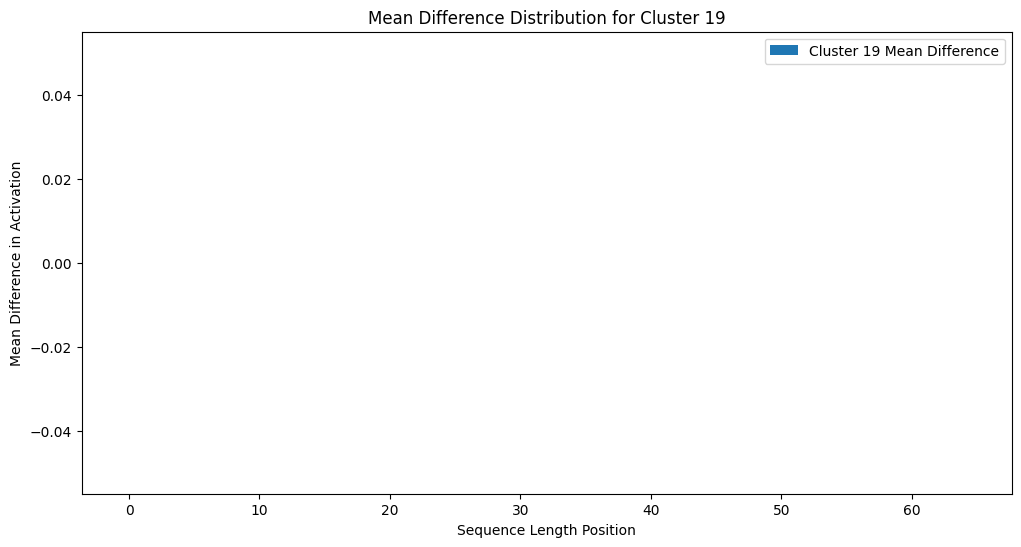

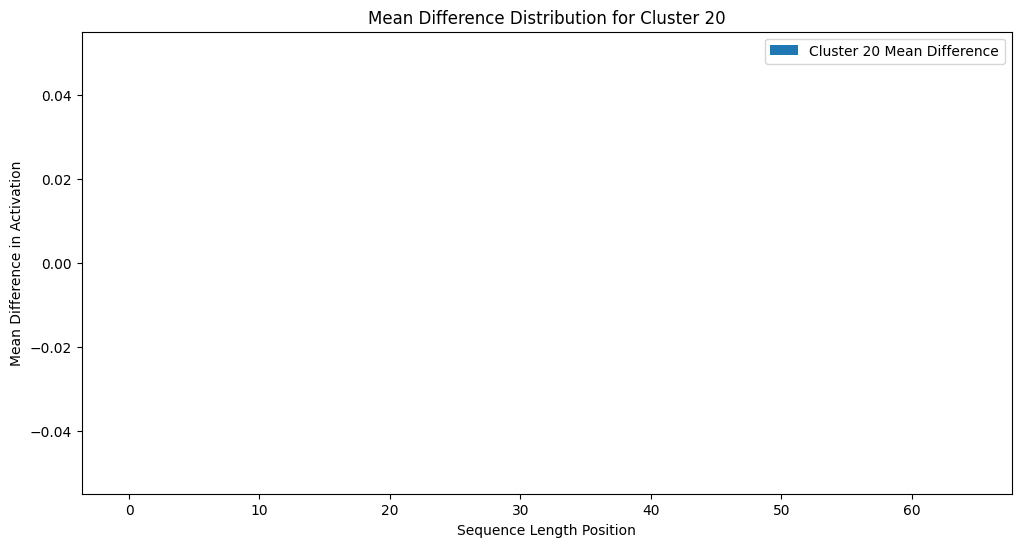

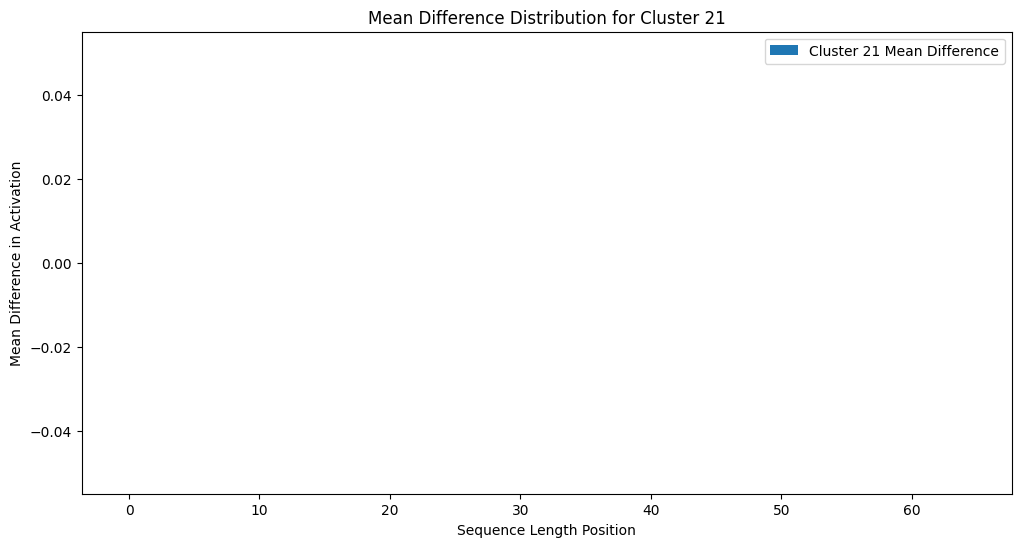

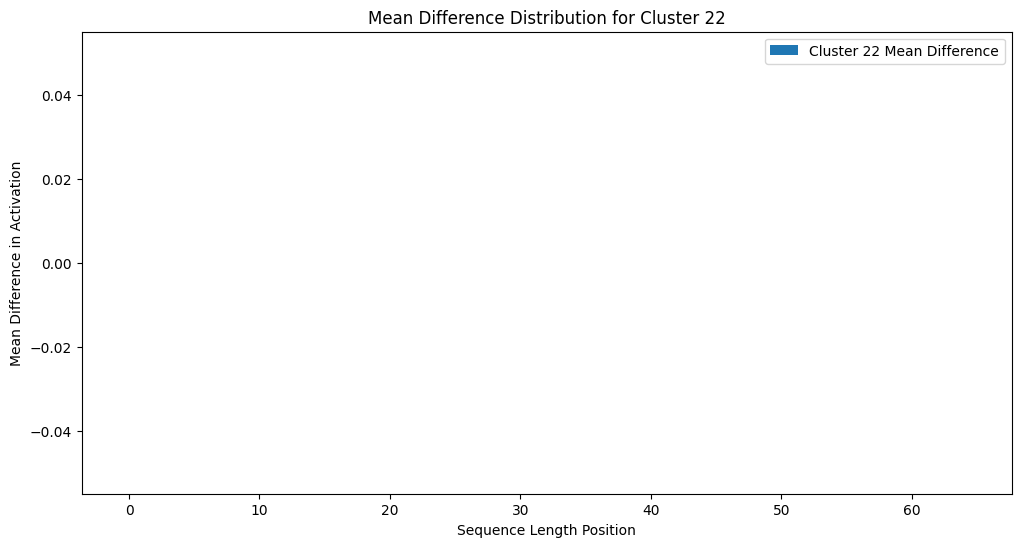

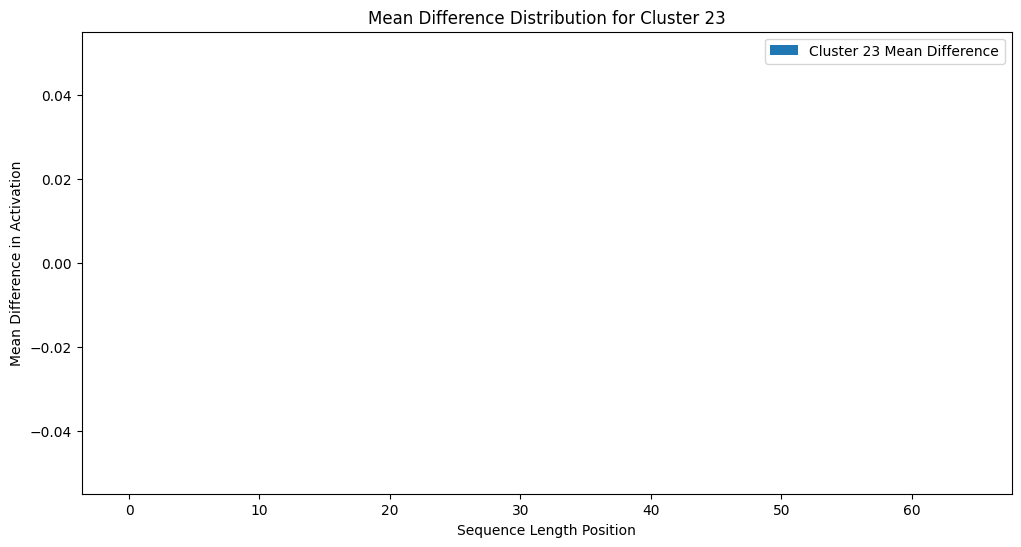

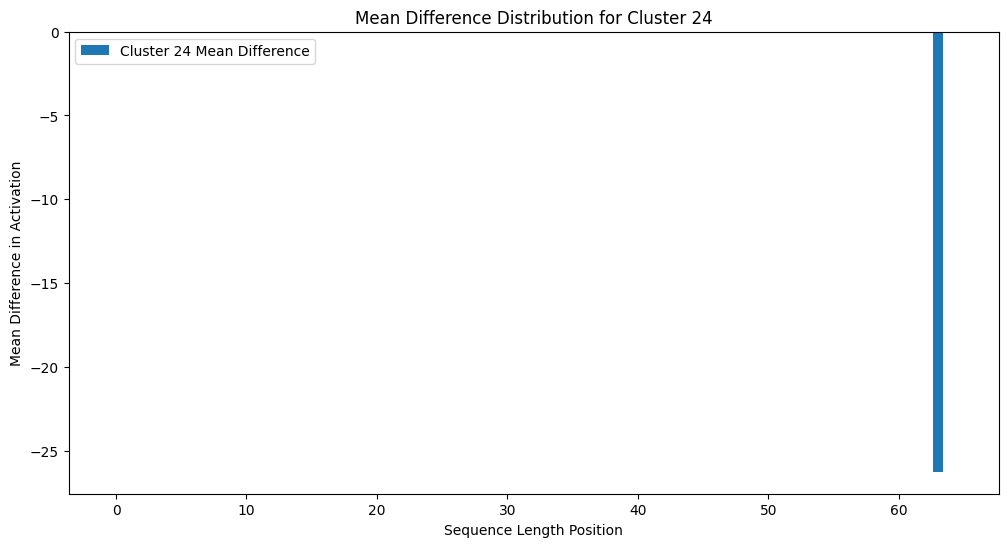

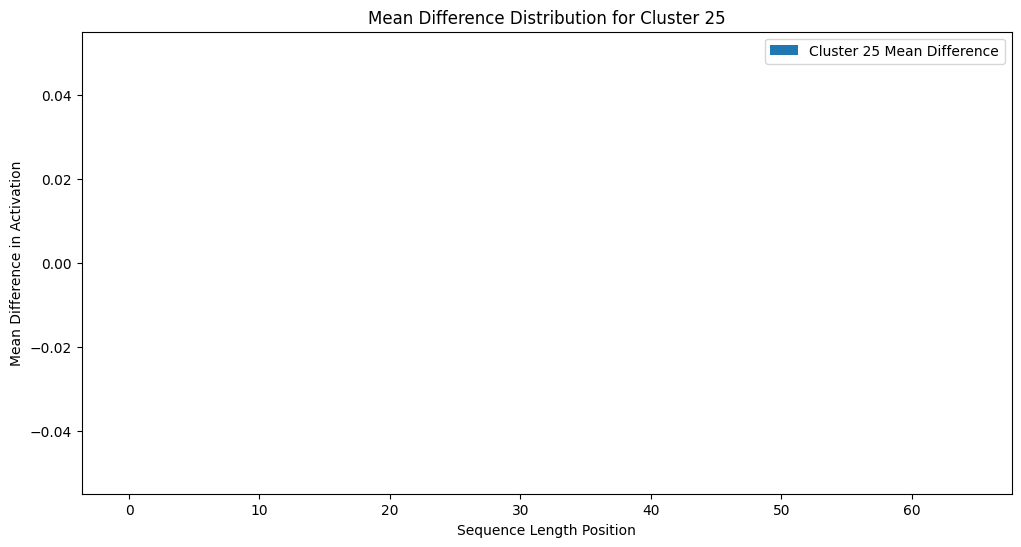

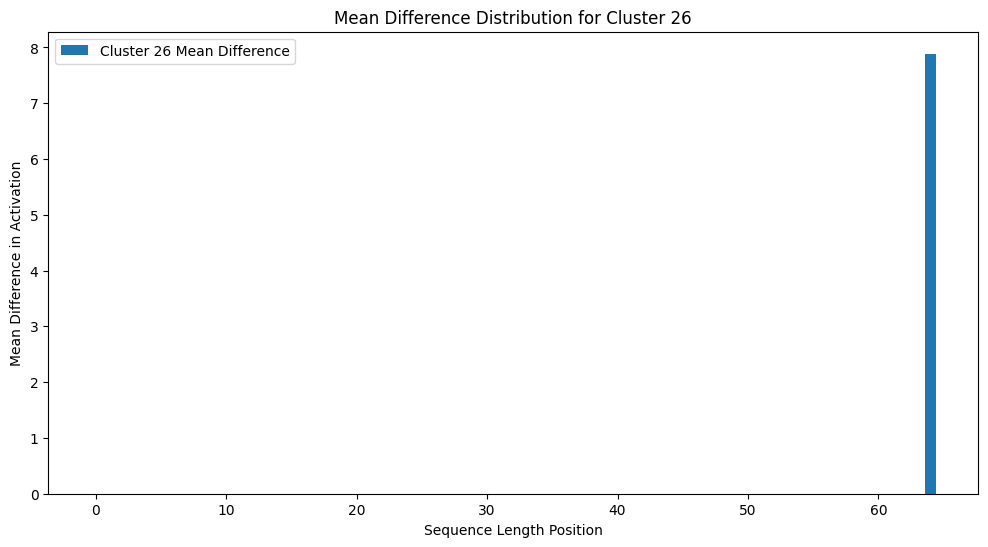

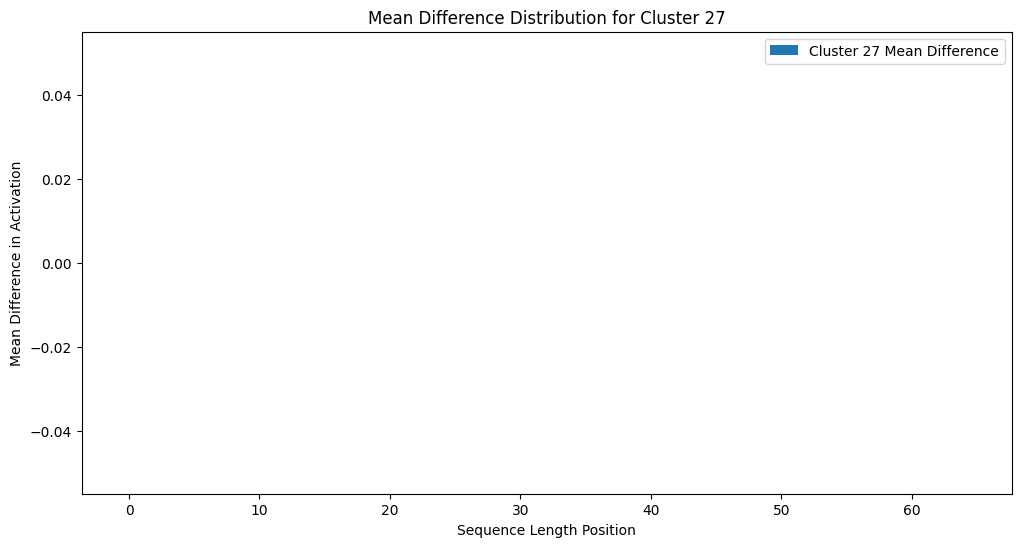

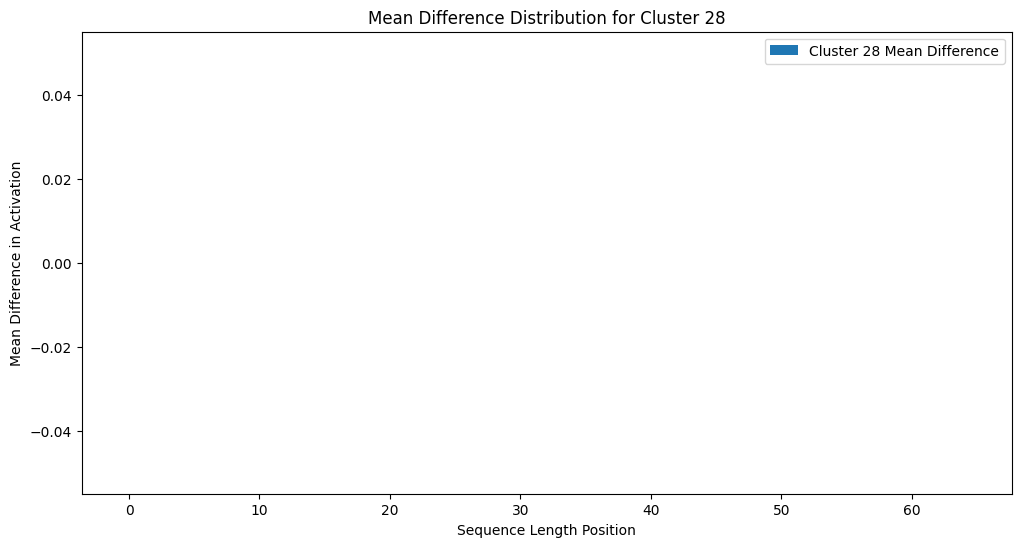

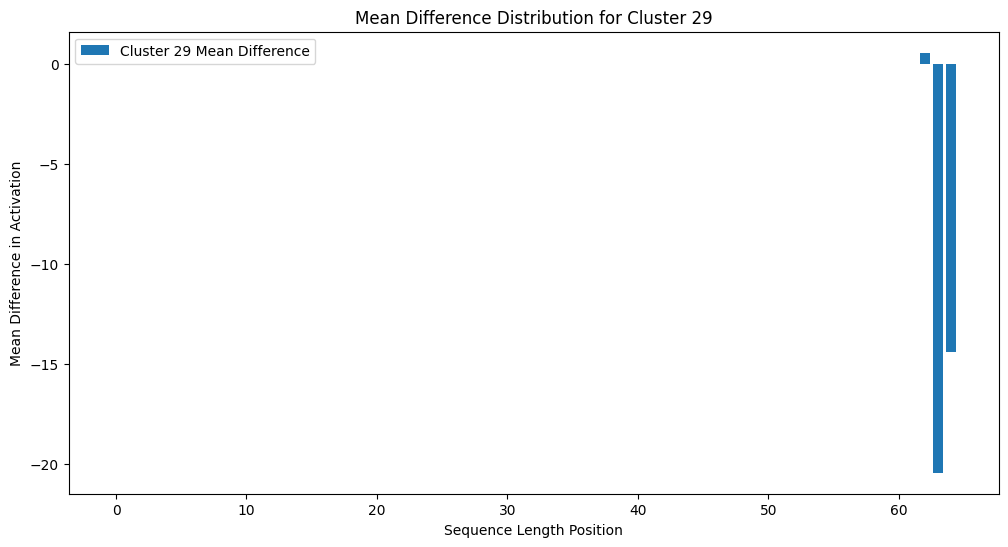

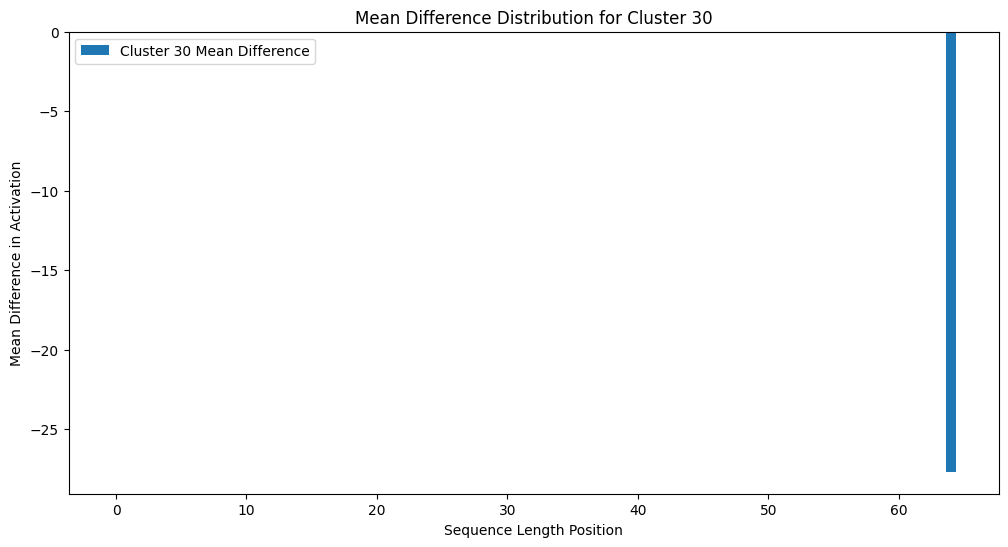

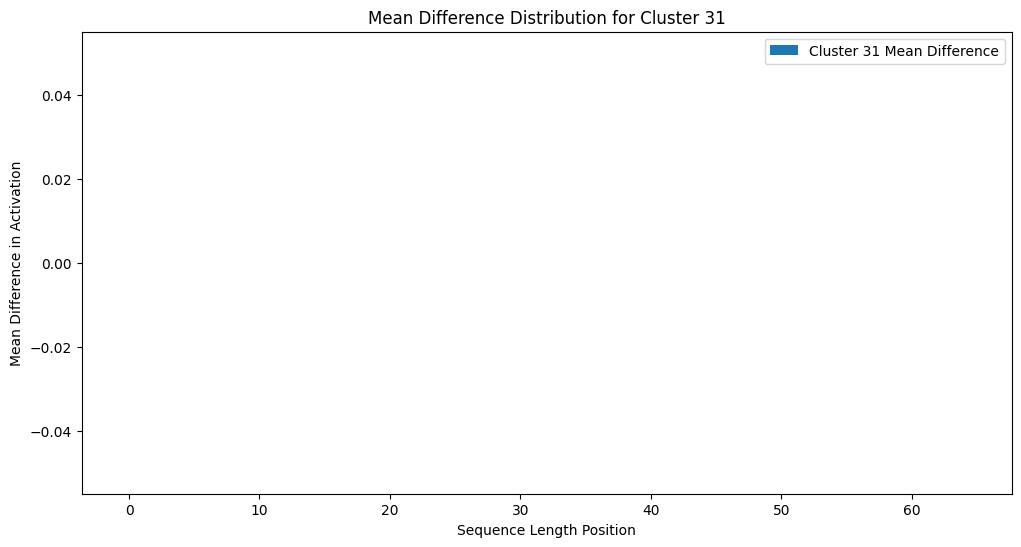

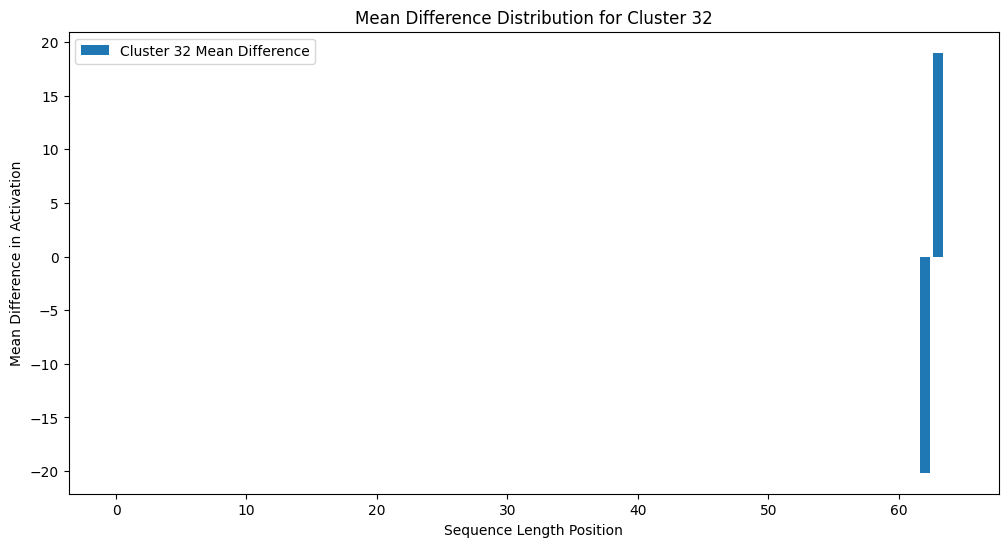

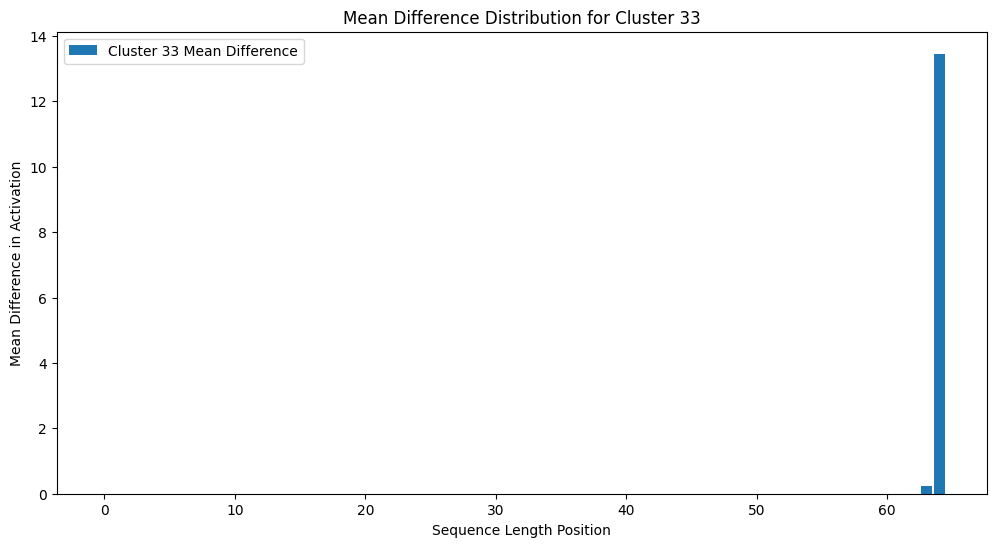

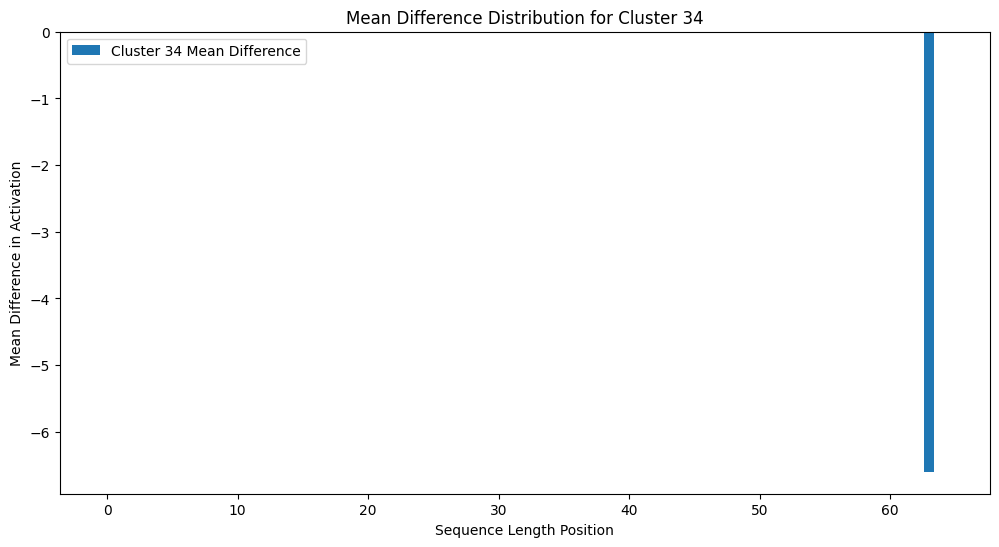

In [41]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

# Define layer and get the combined vectors and diff vectors
layer = 'blocks.40.hook_resid_post'
combined_vectors_layer = combined_vectors[layer]
diff_vectors_layer = diff_vectors[layer]
clusters = grouped_latents_sum[layer]

import matplotlib.pyplot as plt
import numpy as np

# Summarization of Mean Difference Distribution for Each Cluster as Bar Plots
cluster_diffs = {}
for cluster_id in np.unique(clusters):
    # Select diff vectors belonging to the current cluster
    cluster_indices = np.where(clusters == cluster_id)[0]
    cluster_diff_vectors = diff_vectors_layer[cluster_indices]
    
    # Calculate the mean difference across latents in this cluster
    cluster_mean_diff = cluster_diff_vectors.mean(dim=0).cpu().numpy()
    cluster_diffs[cluster_id] = cluster_mean_diff

    # Plot the mean diff distribution for this cluster as a bar plot
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(cluster_mean_diff)), cluster_mean_diff, label=f'Cluster {cluster_id} Mean Difference')
    plt.title(f'Mean Difference Distribution for Cluster {cluster_id}')
    plt.xlabel('Sequence Length Position')
    plt.ylabel('Mean Difference in Activation')
    plt.legend()
    plt.show()

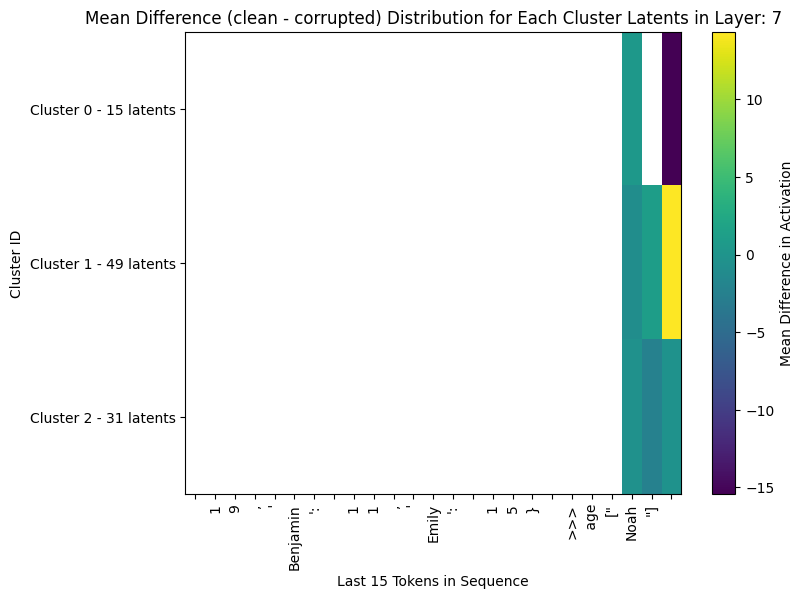

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import torch
# import matplotlib.colors as mcolors
# Assuming `model.to_str_tokens(clean_prompt[0])` provides the token labels for the x-axis
layer = 'blocks.40.hook_resid_post'
combined_vectors_layer = combined_vectors[layer]
diff_vectors_layer = diff_vectors[layer]
clusters = grouped_latents_diff[layer]
tokens = model.to_str_tokens(clean_prompts[0])  # Get token labels for sequence length positions

# Summarization of Mean Difference Distribution for Each Cluster as a Heatmap
cluster_diffs = {}
heatmap_data = []
latents_per_cluster = []
for cluster_id in np.unique(clusters):
    # Select diff vectors belonging to the current cluster
    cluster_indices = np.where(clusters == cluster_id)[0]
    cluster_diff_vectors = diff_vectors_layer[cluster_indices]
    latents_per_cluster.append(len(cluster_indices))
    # Calculate the mean difference across latents in this cluster
    cluster_mean_diff = cluster_diff_vectors.mean(dim=0).cpu().numpy()
    cluster_diffs[cluster_id] = cluster_mean_diff
    heatmap_data.append(cluster_mean_diff)  # Collect for heatmap plot

# Convert to numpy array for plotting, with each row as a cluster and columns as sequence length positions
heatmap_data = np.array(heatmap_data)

# Select only the last 5 tokens
heatmap_data = heatmap_data[:, -25:]
tokens = tokens[-25:]

# Create a color map with white for zero values
cmap = plt.cm.viridis
cmap.set_bad(color='white')

# Mask zeros in the heatmap data for white color
masked_heatmap_data = np.ma.masked_where(heatmap_data == 0, heatmap_data)

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(masked_heatmap_data, aspect='auto', cmap=cmap, interpolation='nearest')
plt.colorbar(label='Mean Difference in Activation')

# Set y-axis to show cluster labels and x-axis to show only the last 5 tokens
plt.yticks(ticks=range(len(cluster_diffs)), labels=[f'Cluster {i} - {latents_per_cluster[i]} latents' for i in range(len(cluster_diffs))])
plt.xticks(ticks=range(len(tokens)), labels=tokens, rotation=90)
layer_ind = 7
plt.title(f'Mean Difference (clean - corrupted) Distribution for Each Cluster Latents in Layer: {layer_ind}')
plt.xlabel('Last 15 Tokens in Sequence')
plt.ylabel('Cluster ID')
plt.show()

In [43]:
from collections import defaultdict

# Initialize a dictionary to hold lists of latent indices for each cluster
cluster_latent_indices = defaultdict(list)

# Iterate over each latent index and its assigned cluster
for idx, cluster_id in enumerate(clusters):
    # Append the index of the latent to the appropriate cluster list
    cluster_latent_indices[cluster_id].append(mask[layer][idx])

# Print the latent indices for each cluster
for cluster_id, indices in cluster_latent_indices.items():
    print(f"Cluster {cluster_id}: Latent Indices: {indices}")

Cluster 1: Latent Indices: [34, 201, 547, 637, 803, 1073, 1435, 2233, 2493, 2534, 2646, 2664, 2930, 3685, 3960, 3987, 5659, 6715, 7604, 7792, 7849, 7874, 8468, 8617, 9230, 9578, 9969, 10000, 10155, 10628, 11066, 11103, 11778, 11839, 11861, 12037, 12258, 12460, 12698, 12851, 12934, 13836, 13925, 14810, 15045, 15628, 15851, 15863, 16039]
Cluster 2: Latent Indices: [88, 215, 589, 907, 1523, 1543, 1666, 2589, 3765, 3958, 4363, 4426, 4729, 5044, 5254, 5908, 6775, 7198, 7272, 7358, 8341, 8510, 8922, 9743, 12069, 12102, 12786, 13477, 13865, 14549, 16064]
Cluster 0: Latent Indices: [3200, 7622, 9092, 9178, 9682, 10316, 11633, 12862, 13380, 13629, 13894, 14423, 14454, 15705, 16231]
